# Credit Card Fraud Detection

__Goal:__

Predict the probability of an online credit card transaction being fraudulent, based on different properties of the transactions.


In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Time
import time
import datetime

# Machine Learning
from   sklearn.preprocessing import LabelEncoder, minmax_scale
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.decomposition import PCA
from   sklearn.model_selection import train_test_split, GridSearchCV
from   sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve
from   sklearn.calibration import calibration_curve
from   sklearn.calibration import CalibratedClassifierCV

from   xgboost import XGBClassifier
from   lightgbm import LGBMClassifier

from   imblearn.over_sampling import RandomOverSampler
from   scipy.stats import chi2_contingency,  f_oneway

import gc
import warnings
from   tqdm import tqdm


# Set Options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
warnings.filterwarnings("ignore")

## Data Overview

Purpose is to:

1. Load the datasets
2. Explore the features

The data is broken into two files **identity** and **transaction**, which are joined by “TransactionID”.

**Note:** Not all transactions have corresponding identity information.

In [ ]:
%%time
# Load Data
df_id   = pd.read_csv('Data/train_identity.csv')
df_tran = pd.read_csv('Data/train_transaction.csv')

Wall time: 26.3 s


In [ ]:
# Identitiy Data
df_id.sample(6)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
601,2990046,-5.0,821814.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,102.0,15.0,410.0,360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,F,F,mobile,iOS Device
29589,3065170,-10.0,103219.0,0.0,0.0,2.0,-5.0,NaN,NaN,0.0,0.0,100.0,Found,52.0,NaN,Found,Found,166.0,13.0,216.0,214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,ie 11.0 for desktop,NaN,NaN,NaN,F,F,T,T,desktop,rv:11.0
97539,3342636,-20.0,175191.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,33.0,NaN,New,NotFound,225.0,NaN,266.0,305.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,samsung browser generic,NaN,NaN,NaN,F,F,T,F,mobile,SAMSUNG SM-G610M Build/NRD90M
141317,3561291,-5.0,135838.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,-480.0,Found,Found,166.0,NaN,193.0,222.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 66.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
65961,3161995,-5.0,22457.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,49.0,-360.0,Found,Found,166.0,NaN,193.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_13_2,chrome 63.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS
138982,3549519,-10.0,417370.0,NaN,NaN,3.0,-23.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,290.0,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,mobile safari 11.0,NaN,NaN,NaN,F,F,T,F,mobile,NaN


### Identity Data Description

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

In [ ]:
# Transaction Data
df_tran.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Transaction Data Description
- __TransactionDT__: timedelta from a given reference datetime (not an actual timestamp)
- __TransactionAMT__: transaction payment amount in USD
- __ProductCD__: product code, the product for each transaction
- __card1 - card6__: payment card information, such as card type, card category, issue bank, country, etc.
- __addr__: address
- __dist__: distance
- **P_ and (R__) emaildomain**: purchaser and recipient email domain
- __C1-C14__: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- __D1-D15__: timedelta, such as days between previous transaction, etc.
- __M1-M9__: match, such as names on card and address, etc.
- __Vxxx__: Vesta engineered rich features, including ranking, counting, and other entity relations.

## Optimizing Memory Used by Data

#### Memory occupied by the dataframe (in mb)

In [ ]:
df_id.memory_usage(deep=True).sum() / 1024**2

157.63398933410645

In [ ]:
df_tran.memory_usage(deep=True).sum() / 1024**2

2100.701406478882

In [ ]:
df_tran.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

In [ ]:
print('int64 min: ', np.iinfo(np.int64).min)
print('int64 max: ', np.iinfo(np.int64).max)

int64 min:  -9223372036854775808
int64 max:  9223372036854775807


In [ ]:
print('int8 min: ', np.iinfo(np.int8).min)
print('int8 max: ', np.iinfo(np.int8).max)

int8 min:  -128
int8 max:  127


In [ ]:
# Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Use the defined function to reduce the memory usage

In [ ]:
# Reduce the memory size of the dataframe
df_id   = reduce_mem_usage(df_id)
df_tran = reduce_mem_usage(df_tran)

Mem. usage decreased to 138.38 Mb (12.2% reduction)
Mem. usage decreased to 867.89 Mb (58.7% reduction)


## Basic Data Stats

Before attempting to solve the problem, it's very important to have a good understanding of data.

The goal of this section is to:
- Get the dimensions of data
- Get the summary of data
- Get various statistics of data

#### Shape of dataframe

In [ ]:
# Dimensions of identity dataset
print(df_id.shape)

(144233, 41)


The dataset has 144233 rows and 41 columns

In [ ]:
# Dimensions of transaction dataset
print(df_tran.shape)

(590540, 394)


The dataset has 590540 rows and 394 columns

__Check how many transactions has ID info__

In [ ]:
# How many had ID info?
df_tran.TransactionID.isin(df_id.TransactionID).sum()

144233

#### Summary of dataframe

In [ ]:
df_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
from pandas_summary import DataFrameSummary
df_id_summary = DataFrameSummary(df_id)
df_id_summary.summary()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,144233,144233,140872,66324,66324,136865,136865,5155,5155,74926,74926,140978,NaN,127320,80044,NaN,NaN,139369,45113,139318,139261,5159,5169,NaN,4747,5132,5163,NaN,NaN,NaN,NaN,NaN,77586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.23633e+06,NaN,174717,0,-0,NaN,NaN,inf,-inf,0,-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,inf,NaN,12.7891,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,178850,0,159652,0,0,0,0,11.3828,26.0781,0,0,0,NaN,0,NaN,NaN,NaN,0,1.56152,NaN,NaN,inf,6.89844,NaN,2.37109,97.4375,32.0938,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987e+06,-100,1,-13,-28,-72,-100,-46,-100,-36,-100,90,NaN,10,-660,NaN,NaN,100,10,100,100,100,10,NaN,11,100,100,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.07714e+06,-10,67992,0,0,0,-6,5,-48,0,0,100,NaN,49,-360,NaN,NaN,166,13,266,256,252,14,NaN,11,321,119,NaN,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.19882e+06,-5,125800,0,0,0,0,14,-34,0,0,100,NaN,52,-300,NaN,NaN,166,15,341,472,252,14,NaN,11,321,149,NaN,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.39292e+06,-5,228749,0,0,1,0,22,-23,0,0,100,NaN,52,-300,NaN,NaN,225,15,427,533,486.5,14,NaN,15,371,169,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,3.57753e+06,0,999595,10,0,52,0,61,0,25,0,100,NaN,64,720,NaN,NaN,229,29,671,661,854,44,NaN,26,548,216,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
counts,144233,144233,140872,66324,66324,136865,136865,5155,5155,74926,74926,140978,144233,127320,80044,140985,129340,139369,45113,139318,139261,5159,5169,5169,4747,5132,5163,5169,140978,140978,77565,140282,77586,73289,77805,140985,140985,140985,140985,140810,118666
uniques,144233,77,115655,24,15,93,101,84,94,46,62,146,2,54,25,3,2,104,18,522,394,490,25,3,12,341,95,2,2,2,75,130,4,260,4,2,2,2,2,2,1786


By looking at the summary of datasets, it's clear there is a lot of missing values in the dataset.

Let's get missing value stats and various other stats of columns in dataframe.

#### Stats on Transaction Dataset


In [ ]:
from pandas_summary import DataFrameSummary
df_tran_summary = DataFrameSummary(df_tran)
df_tran_summary.summary()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,590540,590540,590540,590540,NaN,590540,581607,588975,NaN,586281,NaN,524834,524834,238269,37627,NaN,NaN,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,589271,309743,327662,421618,280699,73187,38917,74926,74926,514518,311253,64717,61952,62187,501427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311253,311253,311253,311253,311253,311253,311253,311253,311253,311253,311253,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,514467,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,421571,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,513444,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,501376,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,590226,81945,81945,81945,81945,81945,81951,81951,81951,81945,81945,81945,81945,81951,81951,81951,81945,81945,81945,81945,81945,81945,81951,81951,81945,81945,81945,81951,81951,81951,139631,139631,139819,139819,139819,139631,139631,139819,139819,139631,139631,139631,139631,139819,139631,139631,139631,139819,139819,139631,139631,139819,139819,139631,139631,139631,139631,139819,139819,139631,139819,139819,139631,139819,139819,139631,139631,139631,139631,139631,139631,139819,139819,139819,139631,139631,139631,139631,139631,139631,130430,130430,130430,141416,141416,141416,130430,130430,130430,130430,141416,130430,130430,130430,130430,130430,130430,141416,130430,130430,130430,141416,141416,130430,130430,130430,130430,130430,141416,130430,130430,130430,130430,141416,141416,130430,130430,130430,141416,141416,130430,130430,141416,130430,130430

__Check class imbalance__

In [ ]:
df_tran.loc[:, 'isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>


Lot of interesting things can be observed here:

- Rows in identity dataset are less than transaction dataset, that means only a subset of transactions in transactions dataset has identity data
- Both datasets have the common and unique key as TransactionID, both can be joined at this unique key
- id_24, id_25, dist2, D7 and many more columns have 90%+ missing values, which means that these columns are probably useless so need to drop it for now
- Columns from V1 to V339 in transaction dataset are numeric whereas columns from id_01 to id_39 are of mixed datatype
- TransactionDT column is a timedelta from a given reference datetime (not an actual timestamp). But reference datetime is not known, so need to assume it and convert it to date format
- Target class is imbalanced. So no need to drop the columns where one category contains the majority of rows

## Data Preprocessing for EDA

The goal of this section is to:
- Merge two datasets
- Drop the columns based on the inferences from previous section
- Create date features from transaction date

Let's start with the first task to merge datasets to form one.

#### Merge the datasets

In [ ]:
# Merge transaction dataset and identity dataset
df = df_tran.merge(df_id, how='left', left_index=True, right_index=True, on='TransactionID')

del df_tran, df_id

gc.collect()

0

Get dimensions of training dataset

In [ ]:
# Dimentions of data
df.shape

(590540, 434)

Since left join was performed on transaction dataset, number of rows are same as transaction dataset.

#### Add missing flag

In [ ]:
# Add flag column for missing values
for col in df.columns:
    df[col+"_missing_flag"] = df[col].isnull()

df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,...,V130_missing_flag,V131_missing_flag,V132_missing_flag,V133_missing_flag,V134_missing_flag,V135_missing_flag,V136_missing_flag,V137_missing_flag,V138_missing_flag,V139_missing_flag,V140_missing_flag,V141_missing_flag,V142_missing_flag,V143_missing_flag,V144_missing_flag,V145_missing_flag,V146_missing_flag,V147_missing_flag,V148_missing_flag,V149_missing_flag,V150_missing_flag,V151_missing_flag,V152_missing_flag,V153_missing_flag,V154_missing_flag,V155_missing_flag,V156_missing_flag,V157_missing_flag,V158_missing_flag,V159_missing_flag,V160_missing_flag,V161_missing_flag,V162_missing_flag,V163_missing_flag,V164_missing_flag,V165_missing_flag,V166_missing_flag,V167_missing_flag,V168_missing_flag,V169_missing_flag,V170_missing_flag,V171_missing_flag,V172_missing_flag,V173_missing_flag,V174_missing_flag,V175_missing_flag,V176_missing_flag,V177_missing_flag,V178_missing_flag,V179_missing_flag,V180_missing_flag,V181_missing_flag,V182_missing_flag,V183_missing_flag,V184_missing_flag,V185_missing_flag,V186_missing_flag,V187_missing_flag,V188_missing_flag,V189_missing_flag,V190_missing_flag,V191_missing_flag,V192_missing_flag,V193_missing_flag,V194_missing_flag,V195_missing_flag,V196_missing_flag,V197_missing_flag,V198_missing_flag,V199_missing_flag,V200_missing_flag,V201_missing_flag,V202_missing_flag,V203_missing_flag,V204_missing_flag,V205_missing_flag,V206_missing_flag,V207_missing_flag,V208_missing_flag,V209_missing_flag,V210_missing_flag,V211_missing_flag,V212_missing_flag,V213_missing_flag,V214_missing_flag,V215_missing_flag,V216_missing_flag,V217_missing_flag,V218_missing_flag,V219_missing_flag,V220_missing_flag,V221_missing_flag,V222_missing_flag,V223_missing_flag,V224_missing_flag,V225_missing_flag,V226_missing_flag,V227_missing_flag,V228_missing_flag,V229_missing_flag,V230_missing_flag,V231_missing_flag,V232_missing_flag,V233_missing_flag,V234_missing_flag,V235_missing_flag,V236_missing_flag,V237_missing_flag,V238_missing_flag,V239_missing_flag,V240_missing_flag,V241_missing_flag,V242_missing_flag,V243_missing_flag,V244_missing_flag,V245_missing_flag,V246_missing_flag,V247_missing_flag,V248_missing_flag,V249_missing_flag,V250_missing_flag,V251_missing_flag,V252_missing_flag,V253_missing_flag,V254_missing_flag,V255_missing_flag,V256_missing_flag,V257_missing_flag,V258_missing_flag,V259_missing_flag,V260_missing_flag,V261_missing_flag,V262_missing_flag,V263_missing_flag,V264_missing_flag,V265_missing_flag,V266_missing_flag,V267_missing_flag,V268_missing_flag,V269_missing_flag,V270_missing_flag,V271_missing_flag,V272_missing_flag,V273_missing_flag,V274_missing_flag,V275_missing_flag,V276_missing_flag,V277_missing_flag,V278_missing_flag,V279_missing_flag,V280_missing_flag,V281_missing_flag,V282_missing_flag,V283_missing_flag,V284_missing_flag,V285_missing_flag,V286_missing_flag,V287_missing_flag,V288_missi

#### Clean Data

Let's drop the columns which may not be useful for our analysis

Create a missing value flag column for the columns we are dropping which have more than 90% missing values, there might be some specific pattern associated with missing values and transaction being fraud

In [ ]:
# Drop the columns where one category contains more than 90% values
drop_cols = []

for col in df.columns:
    missing_share = df[col].isnull().sum()/df.shape[0]
    if missing_share > 0.9:
        drop_cols.append(col)
        print(col)
        # df[col + "_missing_flag"] = df[col].isnull()

good_cols = [col for col in df.columns if col not in drop_cols]

dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27


Remove the columns which doesn't having any variance

In [ ]:
# Drop the columns which have only one unique value
drop_cols = []
for col in good_cols:
    unique_value = df[col].nunique()
    if unique_value == 1:
        drop_cols.append(col)
        print(col)
good_cols = [col for col in good_cols if col not in drop_cols]

TransactionID_missing_flag
isFraud_missing_flag
TransactionDT_missing_flag
TransactionAmt_missing_flag
ProductCD_missing_flag
card1_missing_flag
C1_missing_flag
C2_missing_flag
C3_missing_flag
C4_missing_flag
C5_missing_flag
C6_missing_flag
C7_missing_flag
C8_missing_flag
C9_missing_flag
C10_missing_flag
C11_missing_flag
C12_missing_flag
C13_missing_flag
C14_missing_flag


Filter the dataset with only good columns

In [ ]:
# Filter the data for relevant columns only
df = df[good_cols]

Get dimentions of training dataset

In [ ]:
# Dimentions of data
df.shape

(590540, 836)

#### Create date features

Let's create date features from TransactionDT features

In [ ]:
# Date features
START_DATE         = '2017-12-01'
startdate          = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df["Date"]         = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df['_Weekdays']    = df['Date'].dt.dayofweek
df['_Hours']       = df['Date'].dt.hour
df['_Days']        = df['Date'].dt.day

In [ ]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1449.38 Mb (0.8% reduction)


## Exploratory Data Analysis

The goal is to:
- Check if the target variable is balanced or is there a need to balance the target variable
- Analyze the transaction amount
- Get insights or relationships from the data which would be useful from business perspective.

### Check distribution of target variable

In [ ]:
# Get count of target class
df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

Let's check the distribution of target class using a bar plot and check the proportion of transactions amounts being fraud

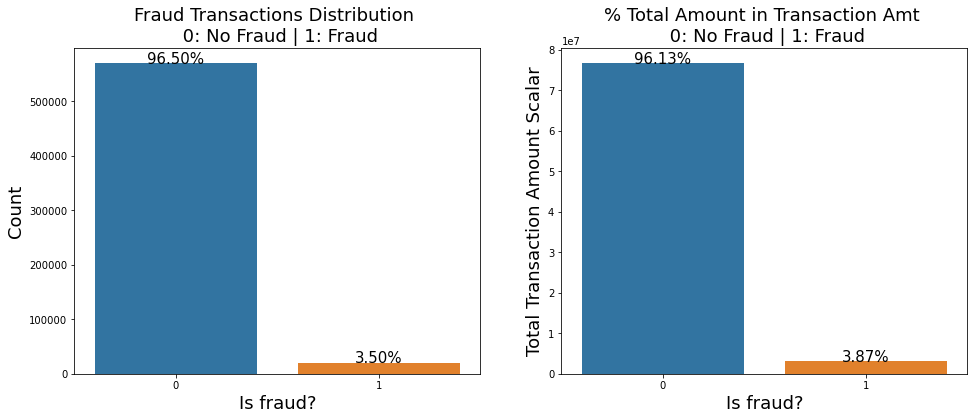

In [ ]:
# Draw a countplot to check the distribution of target variable
df['TransactionAmt'] = df['TransactionAmt'].astype(float)
total = len(df)
total_amt = df.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df )
g.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15)

perc_amt = (df.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()

plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15)

plt.show()

In [ ]:
# Average transaction amount by Y
df.groupby('isFraud')['TransactionAmt'].mean()

isFraud
0    134.511857
1    149.244353
Name: TransactionAmt, dtype: float64

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- The target variable is **imbalanced**. 3.5% transactions are Fraud
- Around same % of transaction amounts are fraud


Let's explore the Transaction amount further

### Check distribution of Transaction Amount

Text(0, 0.5, 'Probability')

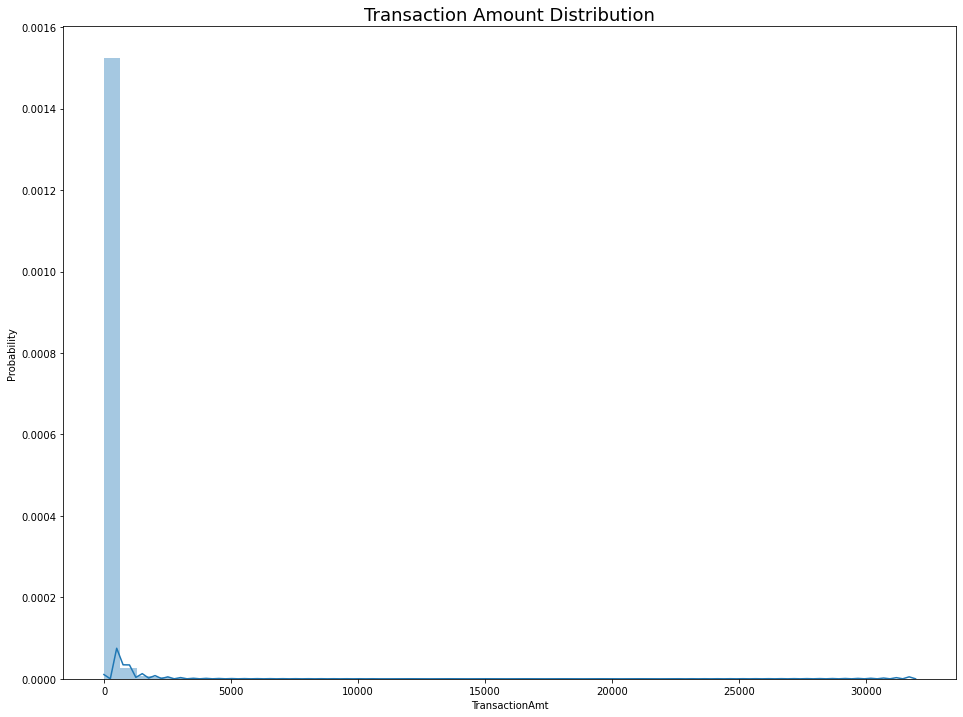

In [ ]:
# Distribution plot of Transaction Amount
plt.figure(figsize=(16,12))

sns.distplot(df['TransactionAmt'])
plt.title("Transaction Amount Distribution",fontsize=18)
plt.ylabel("Probability")

There are certain transactions which are of very high amount, let's remove those to check the distribution

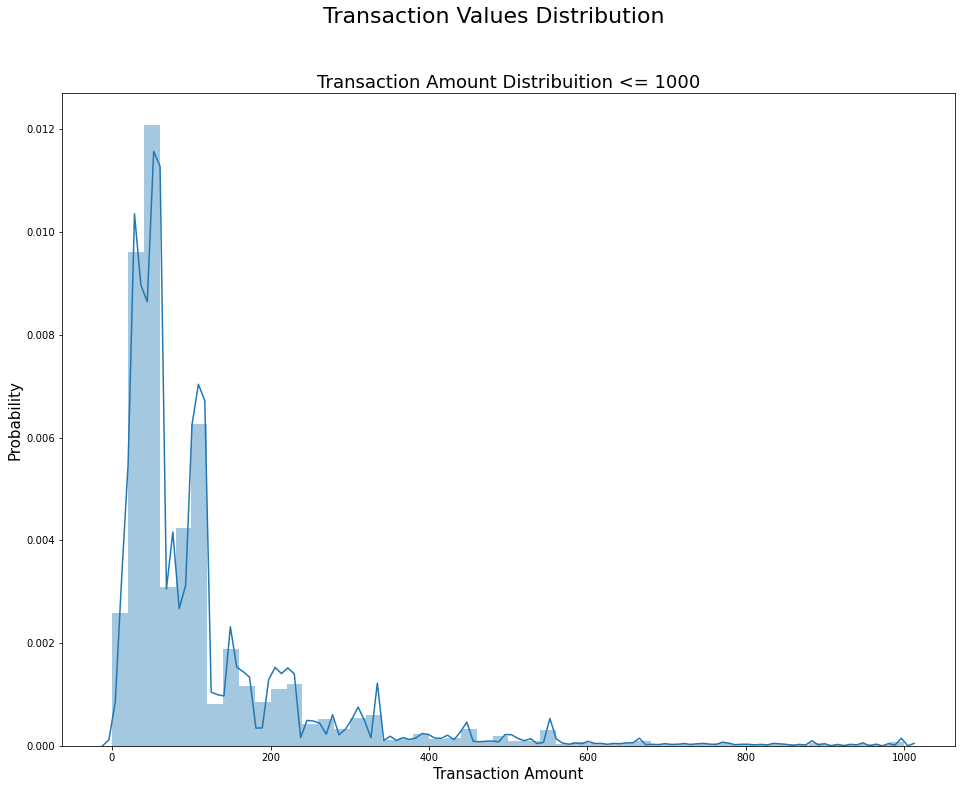

In [ ]:
# Distribution plot of Transaction Amount less than 1000
plt.figure(figsize=(16,12))

plt.suptitle('Transaction Values Distribution', fontsize=22)
sns.distplot(df[df['TransactionAmt'] <= 1000]['TransactionAmt'])
plt.title("Transaction Amount Distribuition <= 1000", fontsize=18)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Probability", fontsize=15)

plt.show()

Most transactions lie in < $200 range

Transaction amount is right skewed.

Let's look at the log of transaction amount

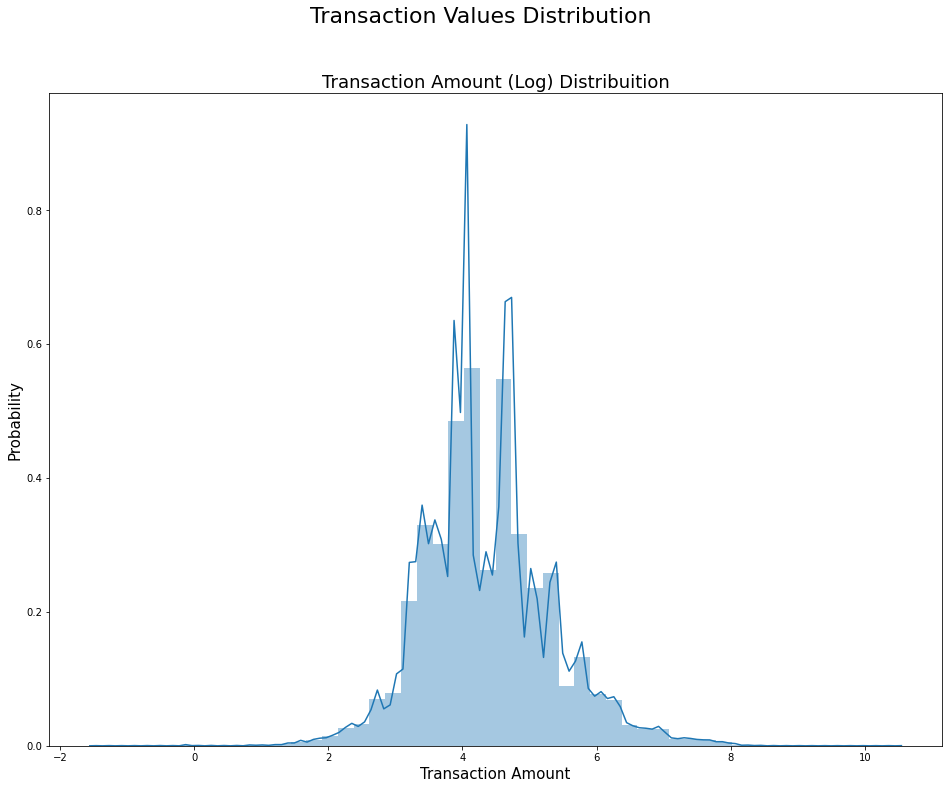

In [ ]:
# Distribution plot of Transaction Amount less than 1000
plt.figure(figsize=(16,12))

plt.suptitle('Transaction Values Distribution', fontsize=22)
sns.distplot(np.log(df['TransactionAmt']))
plt.title("Transaction Amount (Log) Distribuition", fontsize=18)
plt.xlabel("Transaction Amount", fontsize=15)
plt.ylabel("Probability", fontsize=15)

plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Transaction Amount is right skewed.
- Log of transaction amount is almost normally distributed, so use log of transaction amount while building the model

### Product Features

- Distribution of ProductCD
- Distribution of Frauds by Product

In [ ]:
def plot_cat_feat_dist(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(16,12))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)

    g.set_title(f"{col} Distribution", fontsize=16)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14)

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} Distribution by Target Variable (isFraud) ", fontsize=16)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)


    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

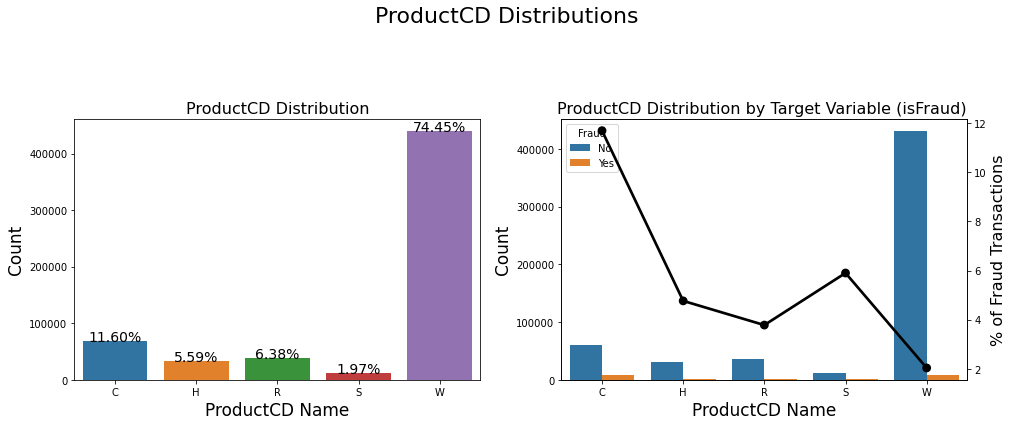

In [ ]:
plot_cat_feat_dist(df, "ProductCD")

In [ ]:
# Average fraud per transaction by ProductCD
df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.116873
H    0.047662
R    0.037826
S    0.058996
W    0.020399
Name: isFraud, dtype: float64

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- 75% of the transactions are for Product Catergory W
- 11.6% of the transactions are for Product Category C
- Fraud Transaction rate is maximum for Product Category C and minimum for Product Category W

### Card Features

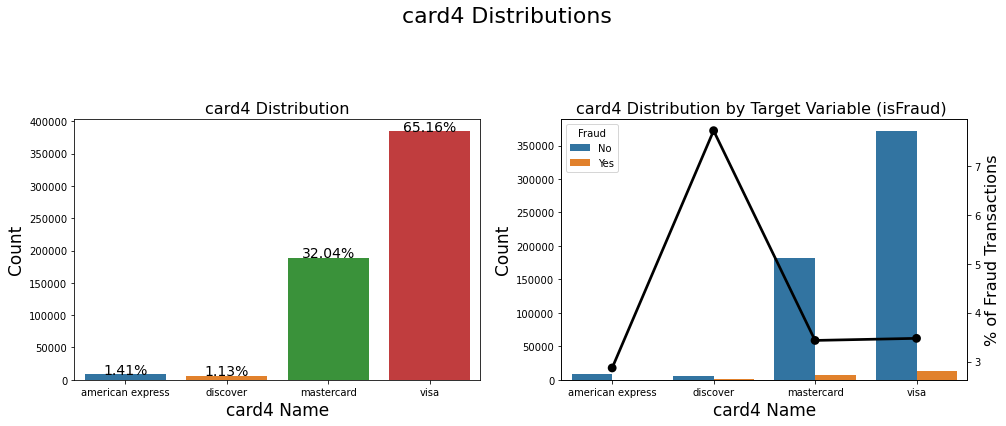

In [ ]:
# Card 4
plot_cat_feat_dist(df, "card4")

In [ ]:
# Average fraud per transaction by Card4
df.groupby('card4')['isFraud'].mean()

card4
american express    0.028698
discover            0.077282
mastercard          0.034331
visa                0.034756
Name: isFraud, dtype: float64

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- 97% of transactions are from Mastercard(32%) and Visa(65%
- Fraud transaction rate is highest for discover cards(~8%) against ~3.5% of Mastercard and Visa and 2.87% in American Express

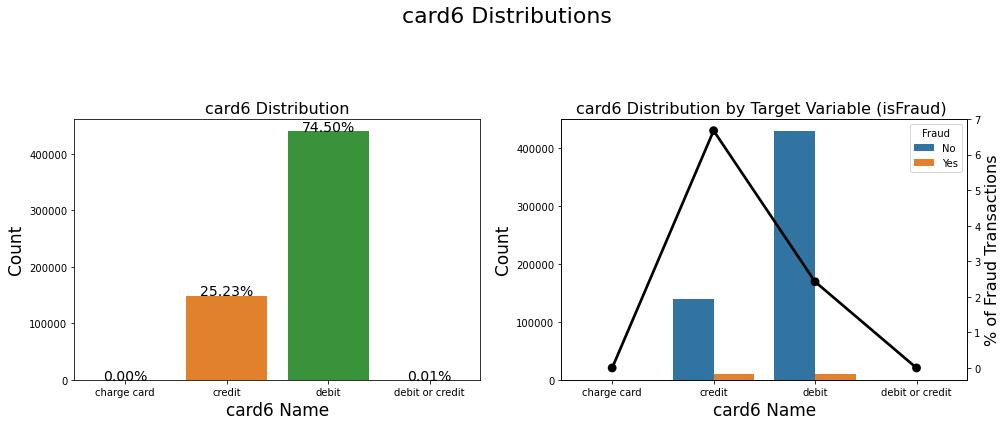

In [ ]:
# Card 6
plot_cat_feat_dist(df, "card6")

In [ ]:
# Average fraud per transaction by Card6
df.groupby('card6')['isFraud'].mean()

card6
charge card        0.000000
credit             0.066785
debit              0.024263
debit or credit    0.000000
Name: isFraud, dtype: float64

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Almost all the transactions are from Credit and Debit cards.
- Debit card transactions are almost 3 times as compared to credit card transactions.
- Fraud transaction rate is high for Credit cards as compared to Debit cards.


### P emaildomain

- It has multiple domains, let's group them by the respective enterprises
- Set all values with less than 500 entries as "Others"

In [ ]:
df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df.loc[df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df.loc[df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx',
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df.loc[df.P_emaildomain.isin(df.P_emaildomain\
                                         .value_counts()[df.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df.P_emaildomain.fillna("NoInf", inplace=True)

In [ ]:
def plot_cat_with_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(16,14))
    plt.suptitle(f'{col} Distributions ', fontsize=24)

    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Share of {col} categories and % of Fraud Transactions", fontsize=18)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12)

    g.set_ylim(0,max(sizes)*1.15)

    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt',
                       data=amt,
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt,
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"Transactions amount by {col} categories and % of Fraud Transactions (Amounts)", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)

    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12)

    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()


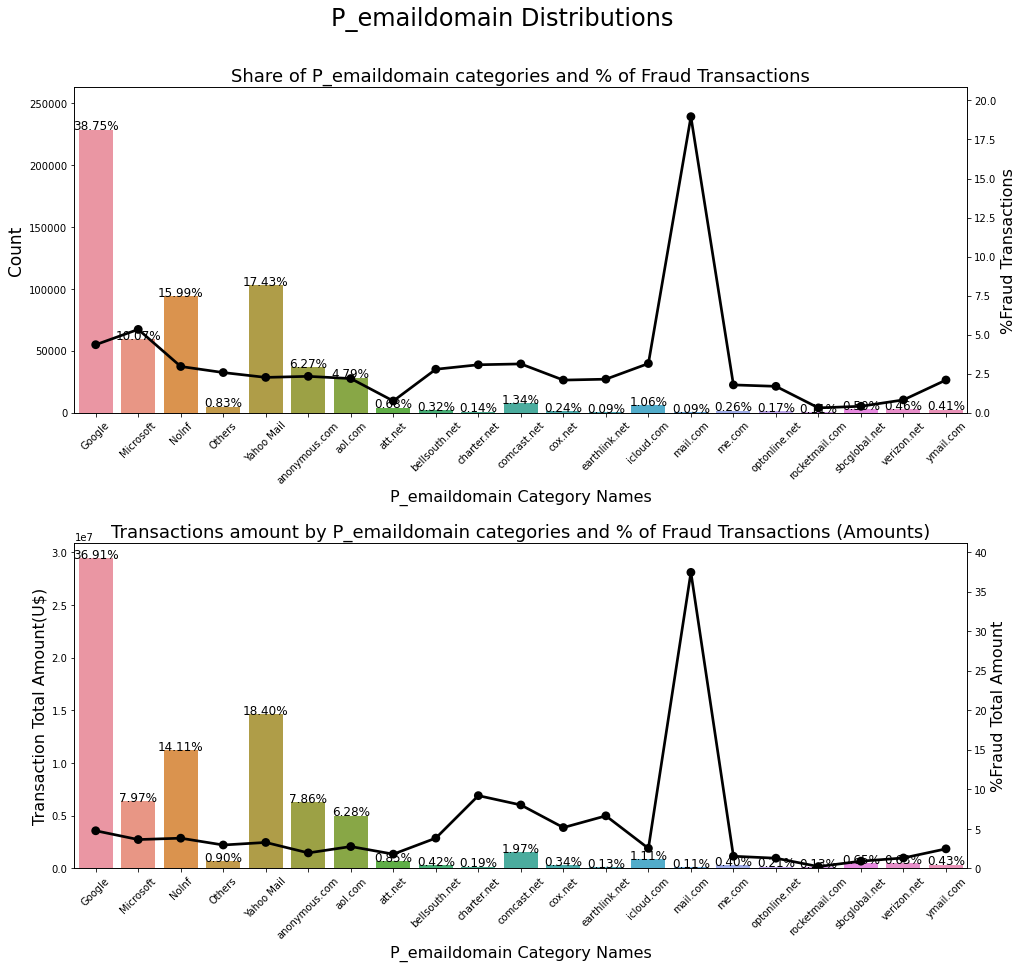

In [ ]:
plot_cat_with_amt(df, 'P_emaildomain')

In [ ]:
# Average fraud per transaction by Card6
df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
aim.com             0.126984
anonymous.com       0.023217
aol.com             0.021811
att.net             0.007439
bellsouth.net       0.027763
cableone.net        0.018868
centurylink.net     0.000000
cfl.rr.com          0.000000
charter.net         0.030637
comcast.net         0.031187
cox.net             0.020818
earthlink.net       0.021401
embarqmail.com      0.034615
frontier.com        0.028571
frontiernet.net     0.025641
gmail               0.022177
gmail.com           0.043542
gmx.de              0.000000
hotmail.co.uk       0.000000
hotmail.com         0.052950
hotmail.de          0.000000
hotmail.es          0.065574
hotmail.fr          0.000000
icloud.com          0.031434
juno.com            0.018634
live.com            0.027622
live.com.mx         0.054740
live.fr             0.000000
mac.com             0.032110
mail.com            0.189624
me.com              0.017740
msn.com             0.021994
netzero.com         0.000000
netzero.net         0.005102


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Majority of transactions are with P_emaildomain as Google, Microsoft and Yahoo Mail
- There isn't any information about P_emaildomain of around 16% transactions in terms of count and 14.11% in terms of amount
- Fraud transaction rate for Microsoft is high as compared to Google and Yahoo mail
- Fraud transaction rate (amount) for Google is high as comapred to Microsoft and Yahoo mail

### R-Email Domain

- It has multiple domains, let's group them by the respective enterprises
- Set all values with less than 500 entries as "Others"

In [ ]:
df.loc[df['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df.loc[df['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df.loc[df['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx',
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df.loc[df.R_emaildomain.isin(df.R_emaildomain\
                                         .value_counts()[df.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df.R_emaildomain.fillna("NoInf", inplace=True)

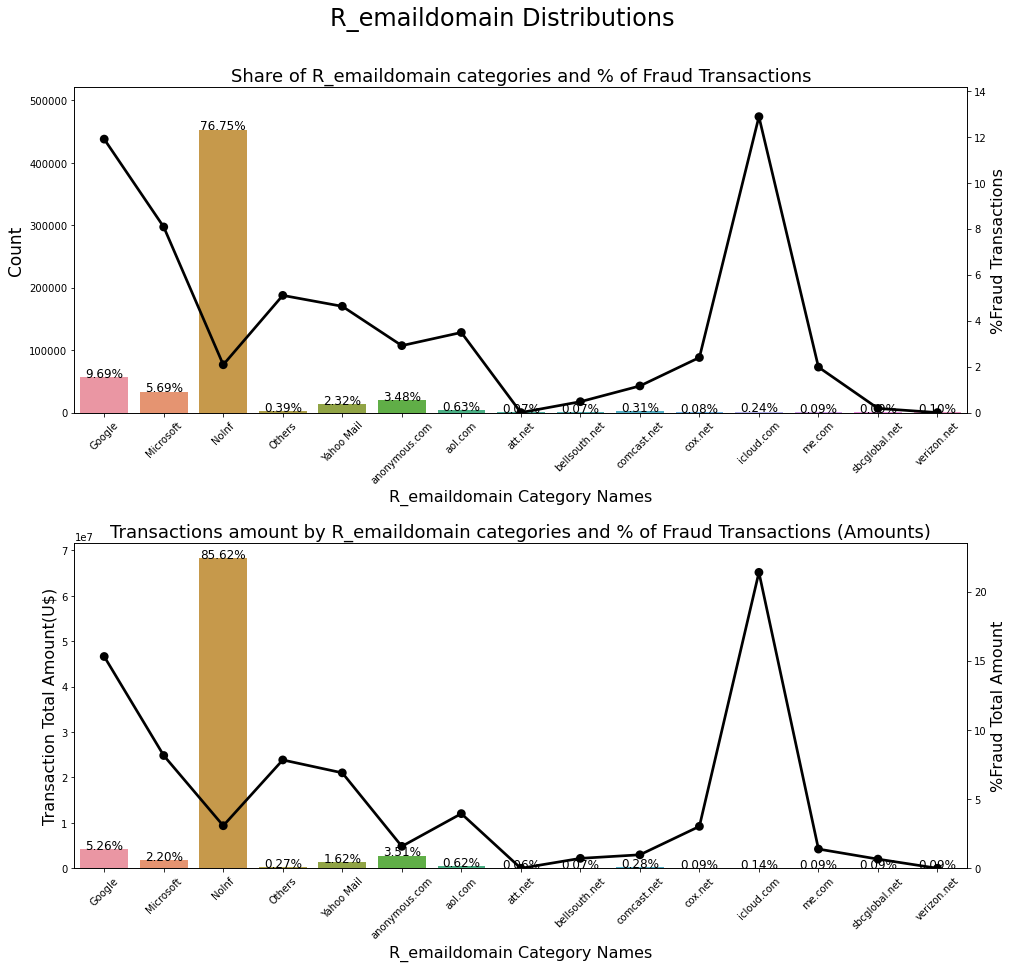

In [ ]:
plot_cat_with_amt(df, 'R_emaildomain')

In [ ]:
# Average fraud per transaction by Card6
df.groupby('R_emaildomain')['isFraud'].mean()

R_emaildomain
aim.com             0.027778
anonymous.com       0.029130
aol.com             0.034855
att.net             0.000000
bellsouth.net       0.004739
cableone.net        0.000000
centurylink.net     0.000000
cfl.rr.com          0.000000
charter.net         0.039370
comcast.net         0.011589
cox.net             0.023965
earthlink.net       0.075949
embarqmail.com      0.000000
frontier.com        0.000000
frontiernet.net     0.000000
gmail               0.000000
gmail.com           0.119184
gmx.de              0.000000
hotmail.co.uk       0.000000
hotmail.com         0.077793
hotmail.de          0.000000
hotmail.es          0.068493
hotmail.fr          0.000000
icloud.com          0.128755
juno.com            0.000000
live.com            0.049869
live.com.mx         0.058355
live.fr             0.000000
mac.com             0.009174
mail.com            0.377049
me.com              0.019784
msn.com             0.001174
netzero.com         0.000000
netzero.net         0.222222


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- There isn't any information about R_emaildomain for Majority of transactions (76.75% count , 85.62% amount)
- Fraud transaction rate for Google is high as compared to Yahoo, anaonymous.com and Microsoft

###  Days of the Month

Reference date is not known, it has been assumed. So can't say concretely if the day number is correct

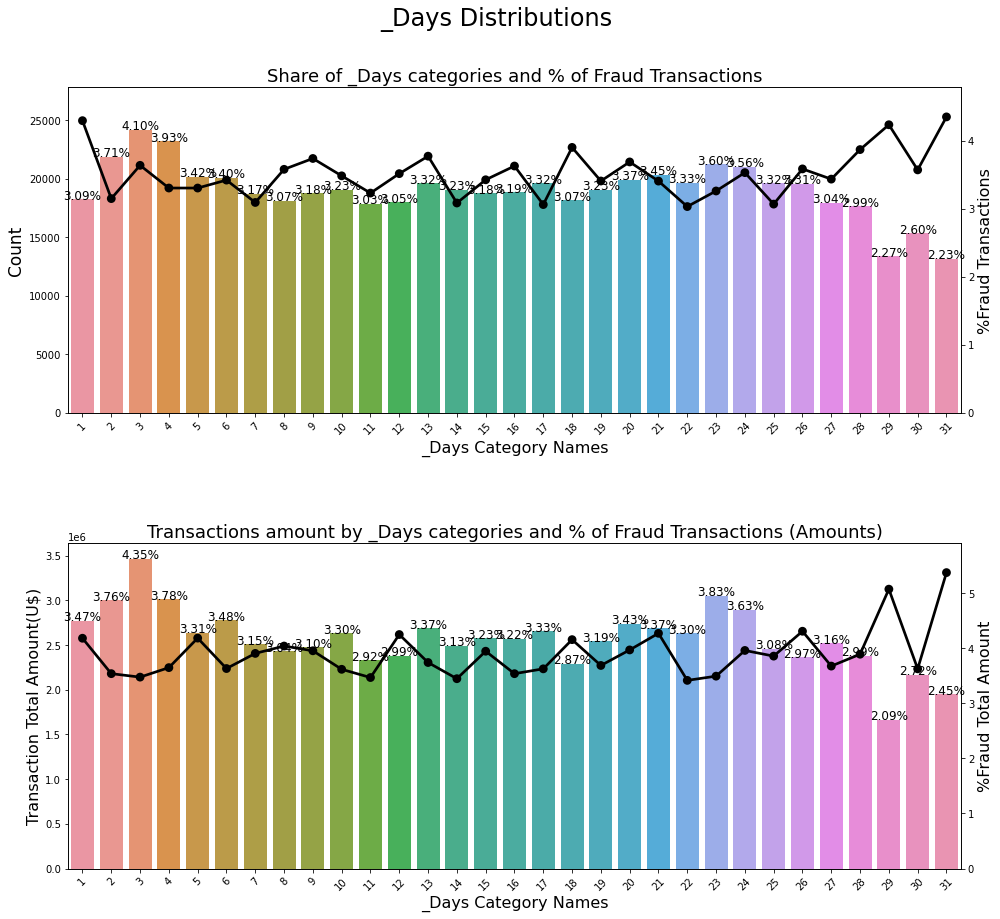

In [ ]:
plot_cat_with_amt(df, '_Days')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- The perc of fraud transactions is highest towards the beginning and the end of the month. Might be accelerated at the time of receiving pay-checks.

- Incidentally, fraud transaction rate is high on the days when number of transactions are less

- Day 29,30 and 31 are having less transactions, looks like people are cautious with spending in those times.

### Days of the week

Reference date is not known, it has been assumed. So can't say concretely if the day number is correct

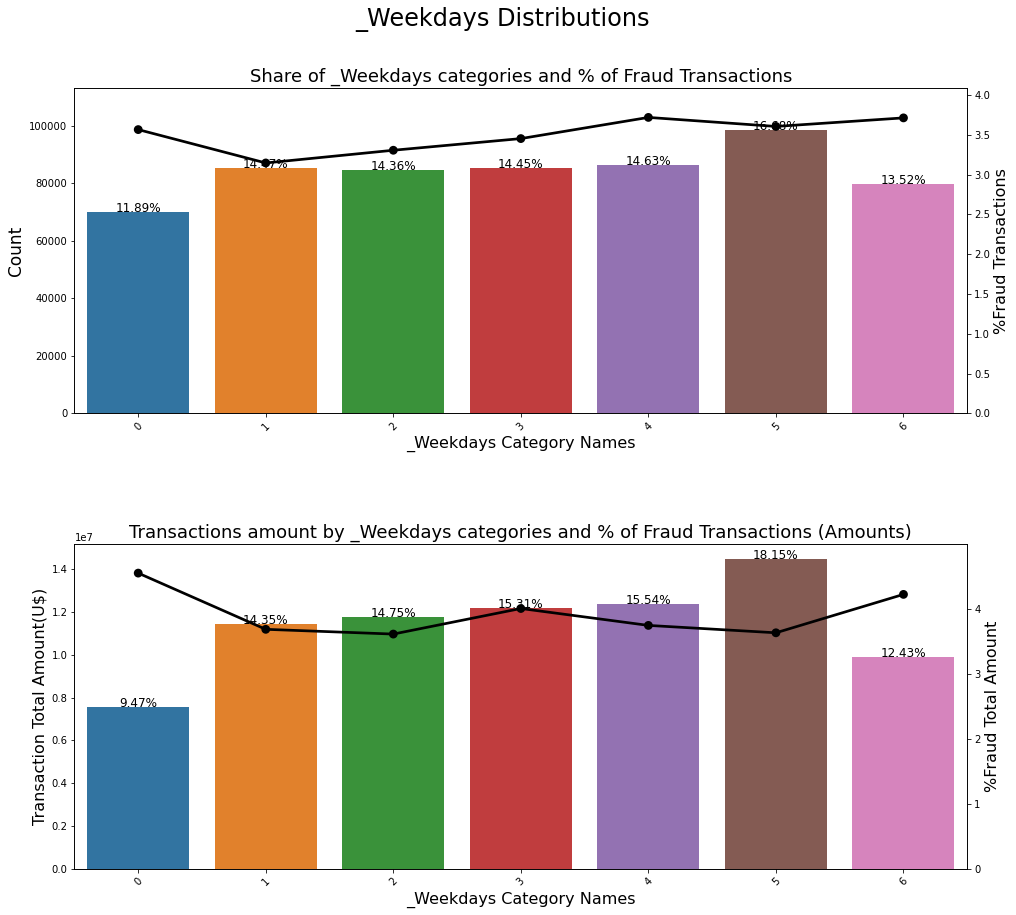

In [ ]:
plot_cat_with_amt(df, '_Weekdays')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Surprisingly fraud transaction rate is high on the days when number of transactions and transaction amounts are less. Day 0 and 6
- Day 0 and 6 have less transactions, these might be weekend days

### Hour of the Day

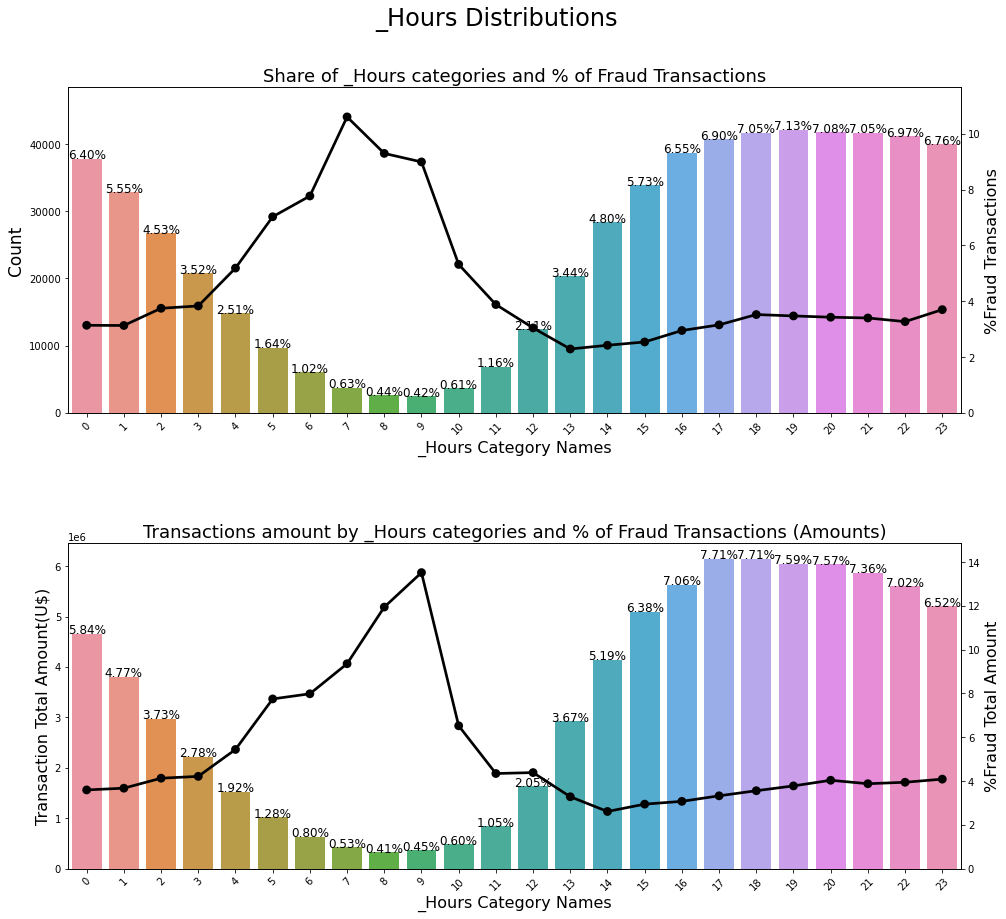

In [ ]:
plot_cat_with_amt(df, '_Hours')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Transactions start decreasing mid night but the fraud rate starts increasing
- Transactions from 3 AM to 12 PM needs to monitored very closely

### Device Type

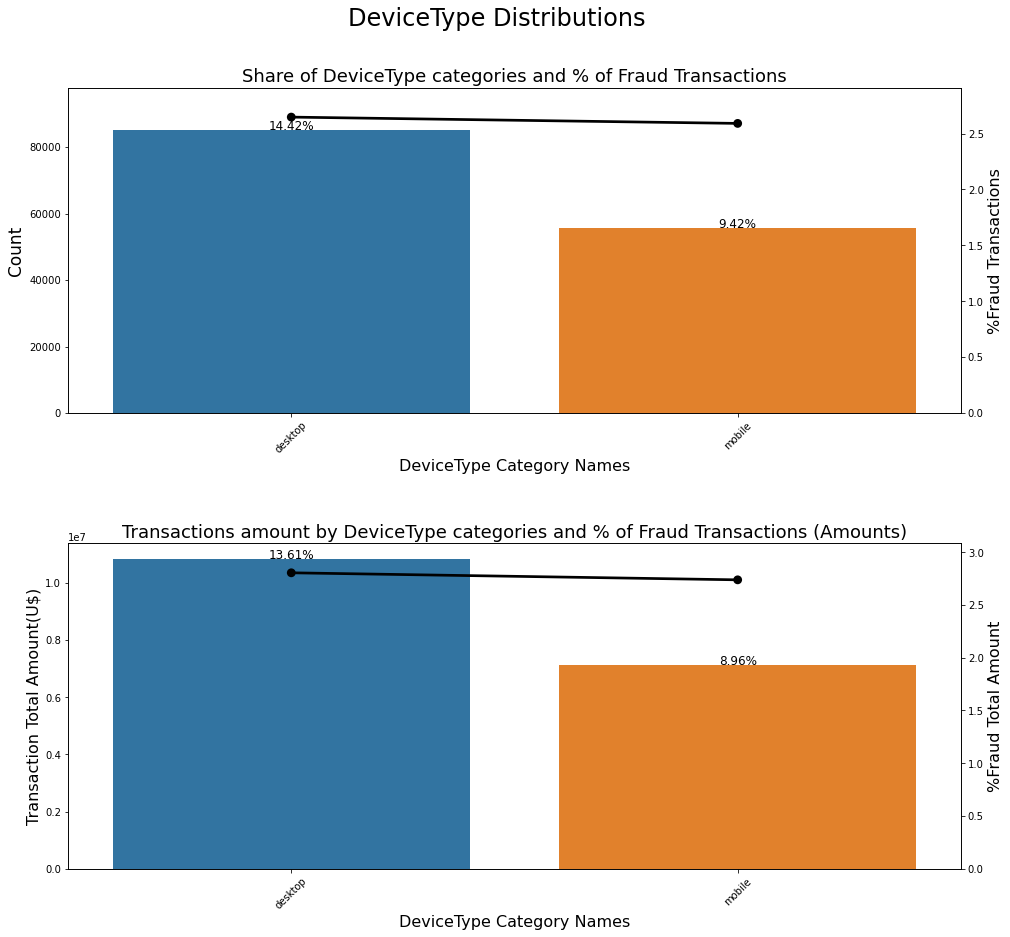

In [ ]:
plot_cat_with_amt(df, "DeviceType")

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Device type is known for only 24% of the transactions
- Due to lack of data points, we can't infer from this analysis

### Columns from identity data

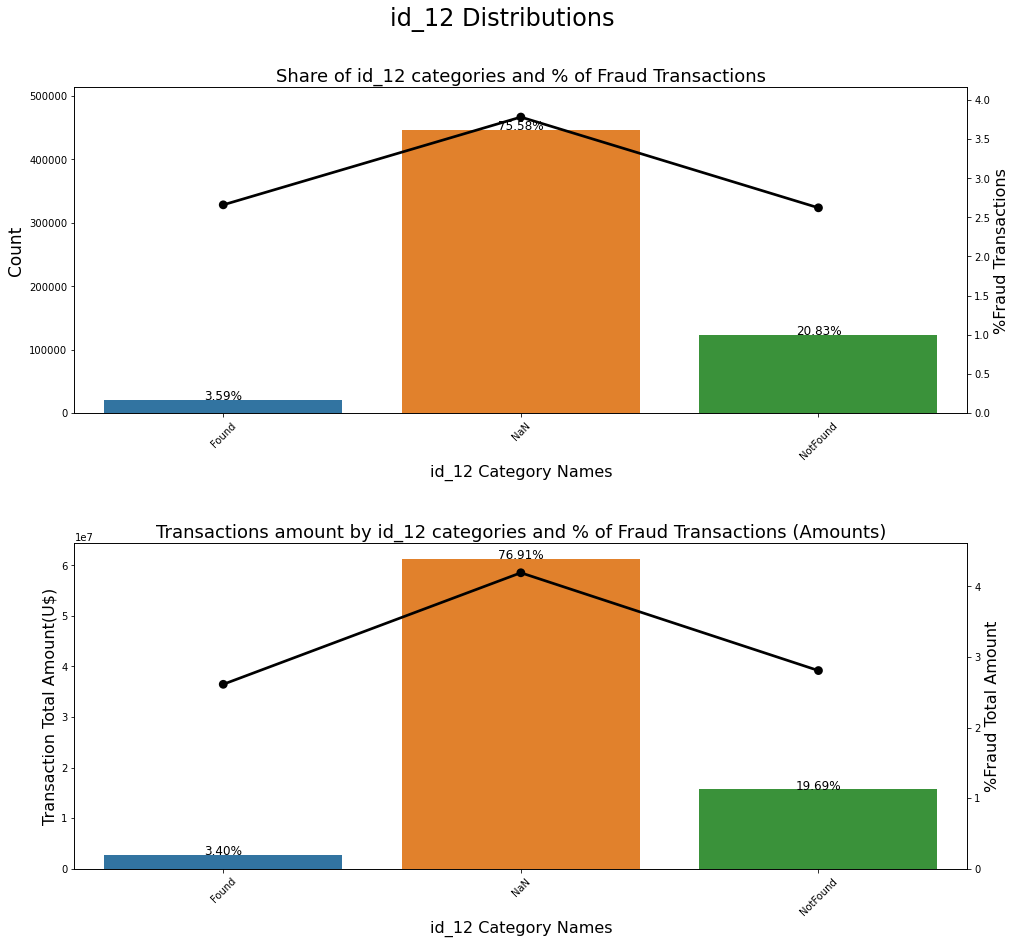

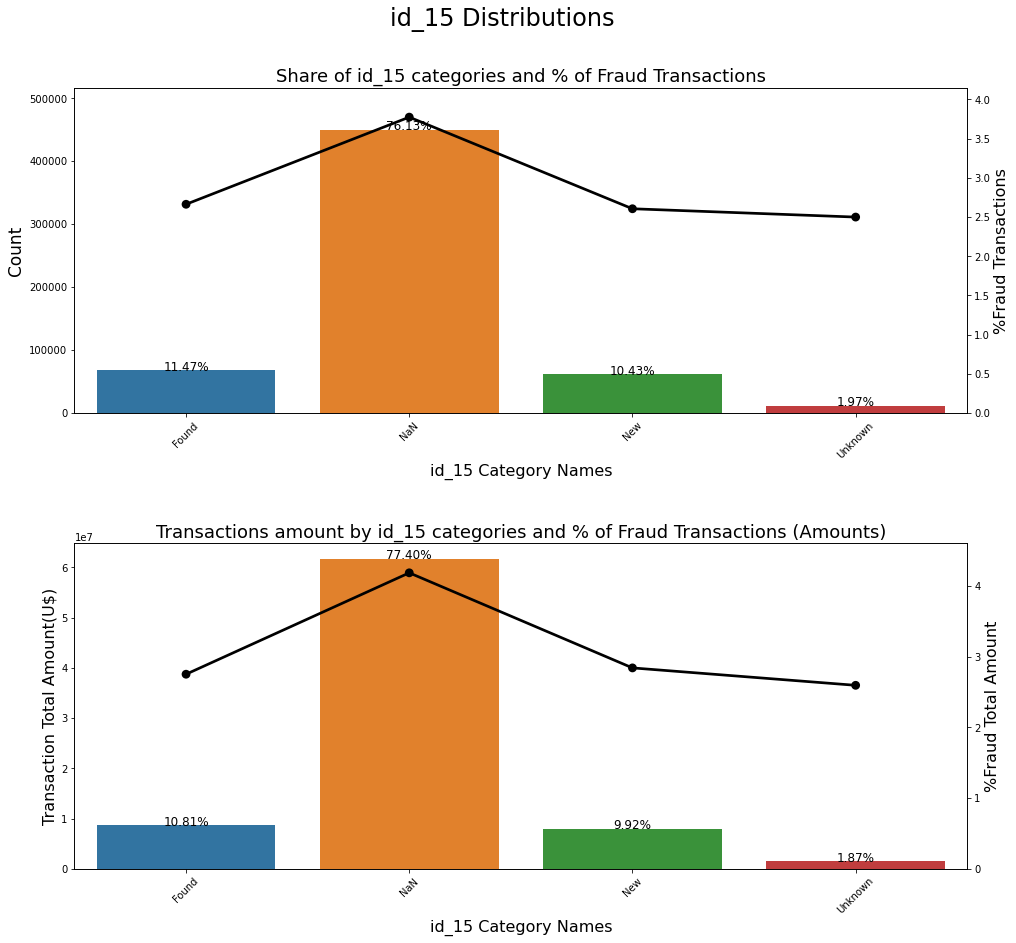

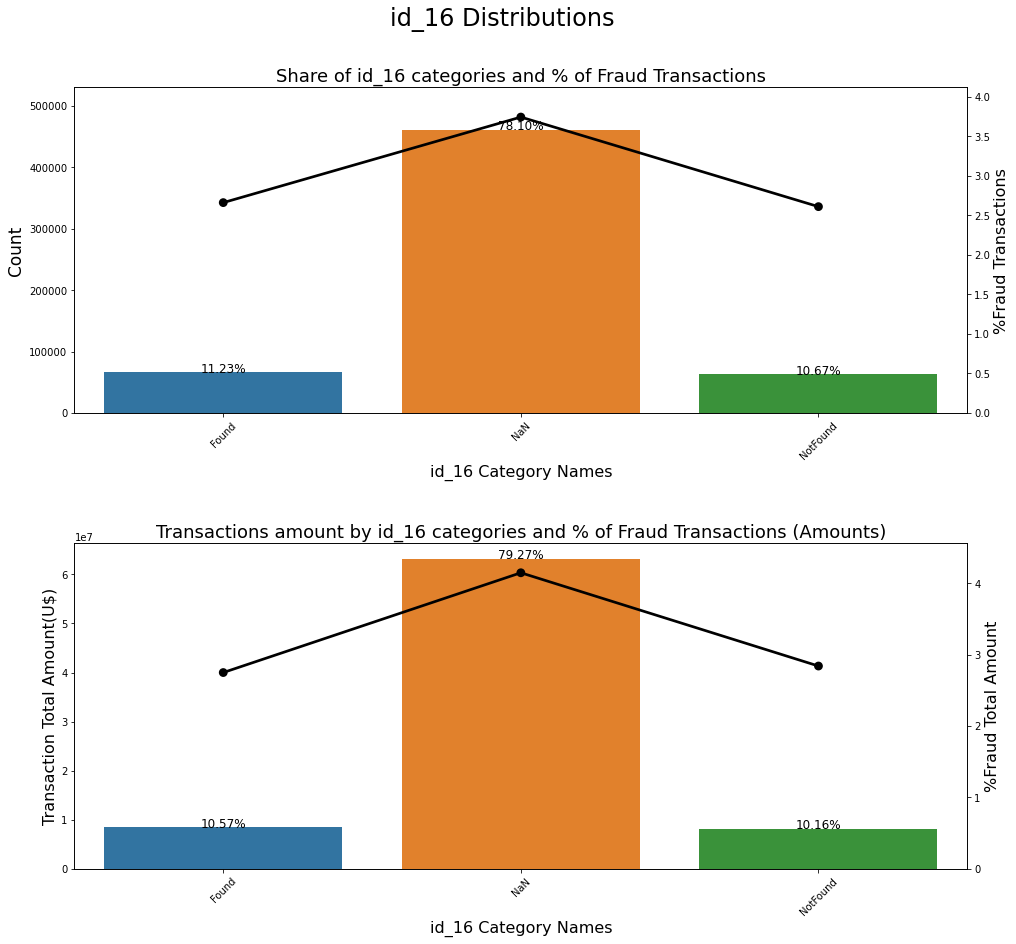

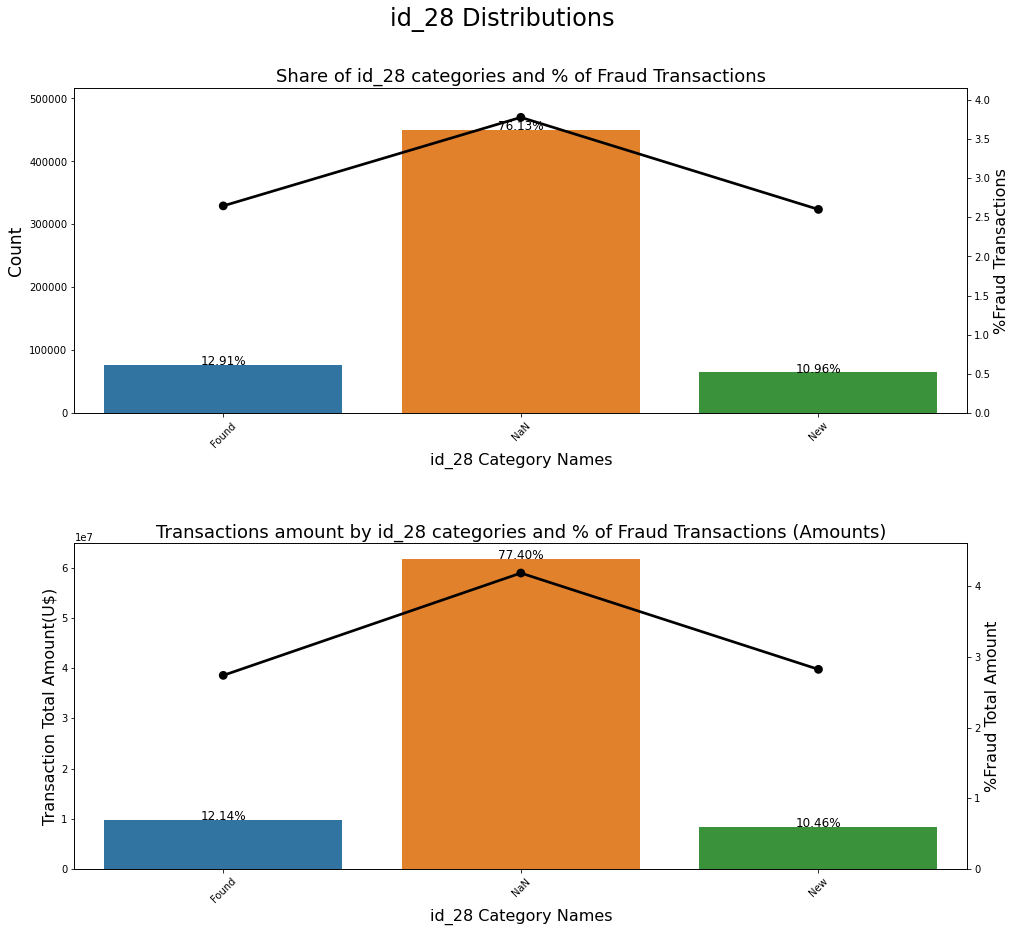

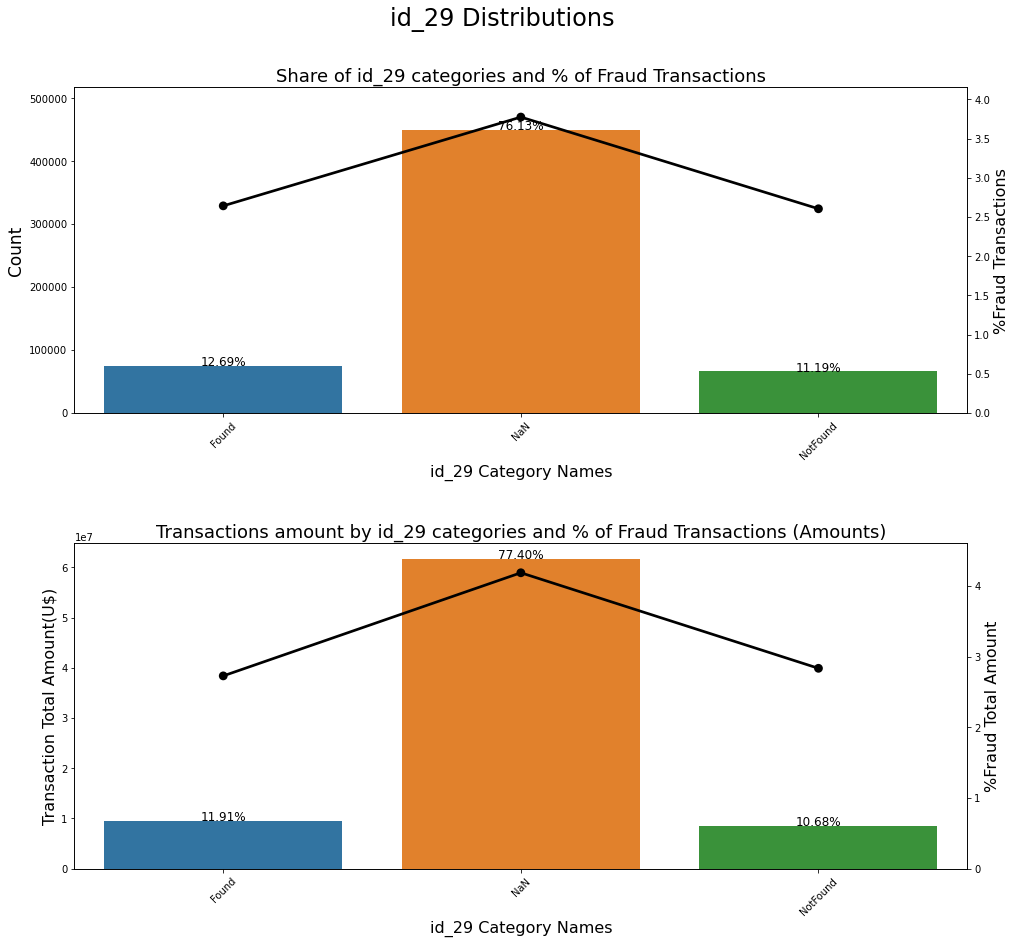

In [ ]:
for col in ['id_12', 'id_15', 'id_16', 'id_28', 'id_29']:
    df[col] = df[col].fillna('NaN')
    plot_cat_with_amt(df, col)

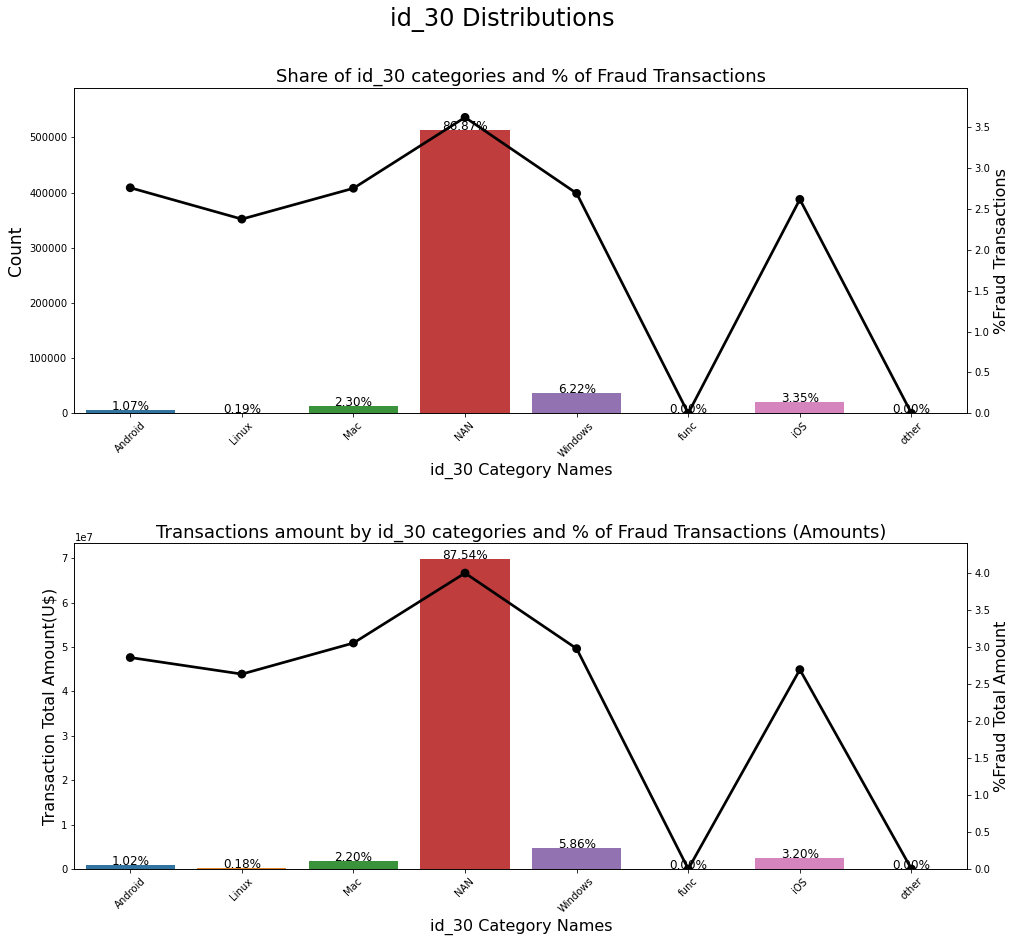

In [ ]:
df.loc[df['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df.loc[df['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df.loc[df['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df.loc[df['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df['id_30'].fillna("NAN", inplace=True)

plot_cat_with_amt(df, "id_30")

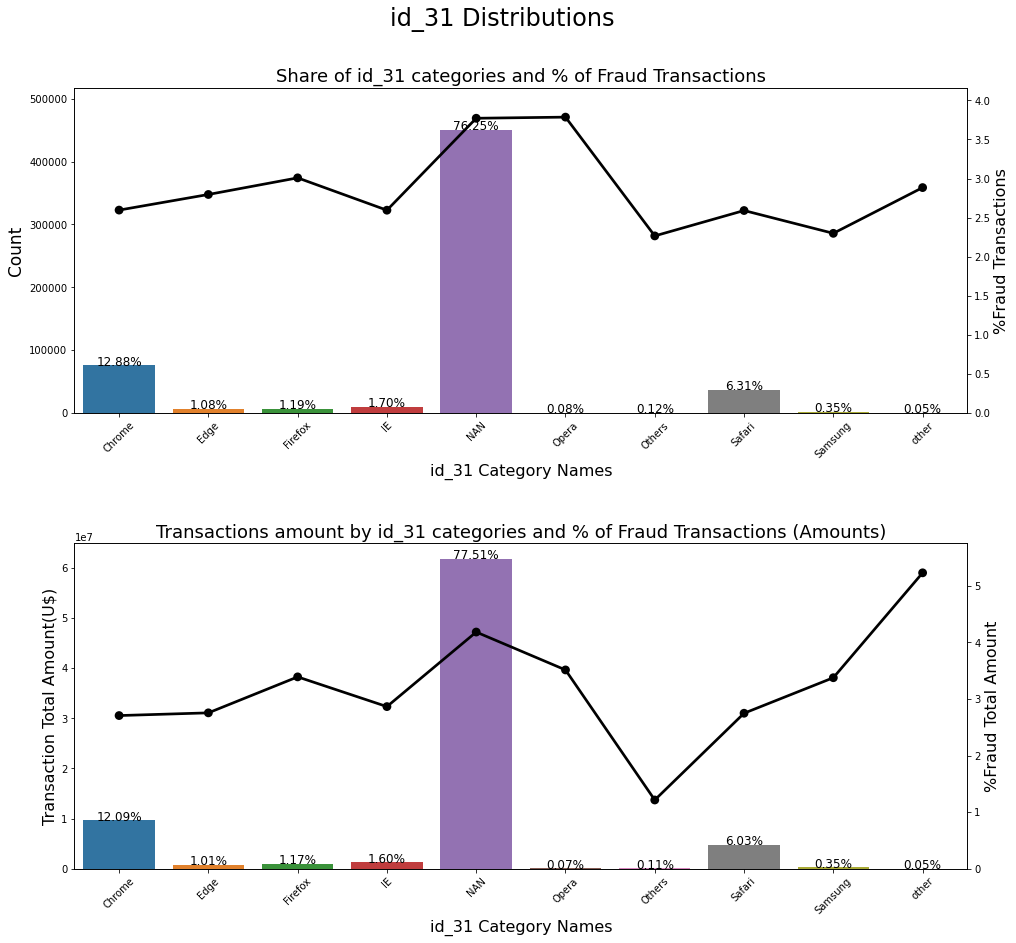

In [ ]:
df.loc[df['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df.loc[df['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df.loc[df['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df.loc[df['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df.loc[df['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df.loc[df['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df.loc[df['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
df['id_31'].fillna("NAN", inplace=True)
df.loc[df.id_31.isin(df.id_31.value_counts()[df.id_31.value_counts() < 200].index), 'id_31'] = "Others"
plot_cat_with_amt(df, "id_31")


### Get column names

In [ ]:
cat_columns = df.select_dtypes(include=['object']).columns
len(cat_columns)

29

In [ ]:
binary_columns = [col for col in df.columns if df[col].nunique() == 2]
len(binary_columns)

435

In [ ]:
num_columns = [col for col in df.columns if (col not in cat_columns) & (col not in binary_columns)]
len(num_columns)

389

In [ ]:
cat_columns = cat_columns.to_list() + binary_columns

## Statistical Significance test

### Chi square test for categorical columns

In [ ]:
from   scipy.stats import chi2_contingency

In [ ]:
# significance value
alpha = 0.05

significant_categorical_variables = []

for col in cat_columns:
    # Create a crosstab table
    temp = pd.crosstab(df[col],df['isFraud'].astype('category'))

    # Get chi-square value , p-value, degrees of freedom, expected frequencies using the function chi2_contingency
    stat, p, dof, expected = chi2_contingency(temp)

    # Determine whether to reject or keep your null hypothesis
    print(col.ljust(40), ',  chisquared=%.5f,   p-value=%.5f' % (stat, p))
    if p <= alpha:
        significant_categorical_variables.append(col)
    else:
        ""

ProductCD                                ,  chisquared=16742.17153,   p-value=0.00000
card4                                    ,  chisquared=364.87414,   p-value=0.00000
card6                                    ,  chisquared=5957.03229,   p-value=0.00000
P_emaildomain                            ,  chisquared=3497.81283,   p-value=0.00000
R_emaildomain                            ,  chisquared=17297.50859,   p-value=0.00000
M1                                       ,  chisquared=0.00003,   p-value=0.99581
M2                                       ,  chisquared=438.61321,   p-value=0.00000
M3                                       ,  chisquared=477.66057,   p-value=0.00000
M4                                       ,  chisquared=6450.44798,   p-value=0.00000
M5                                       ,  chisquared=242.42169,   p-value=0.00000
M6                                       ,  chisquared=227.96414,   p-value=0.00000
M7                                       ,  chisquared=11.25610,   p-va

V14_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V15_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V16_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V17_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V18_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V19_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V20_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V21_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V22_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V23_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V24_missing_flag                         ,  chisquared=670.26786,   p-value=0.00000
V25_missing_flag                         ,  chisquared=670.26786,   p-value=

V114_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V115_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V116_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V117_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V118_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V119_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V120_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V121_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V122_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V123_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V124_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V125_missing_flag                        ,  chisquared=2.86829,   p-value=0.09034
V126_missing_fla

V213_missing_flag                        ,  chisquared=10515.97912,   p-value=0.00000
V214_missing_flag                        ,  chisquared=10515.97912,   p-value=0.00000
V215_missing_flag                        ,  chisquared=10515.97912,   p-value=0.00000
V216_missing_flag                        ,  chisquared=10515.97912,   p-value=0.00000
V217_missing_flag                        ,  chisquared=9230.05652,   p-value=0.00000
V218_missing_flag                        ,  chisquared=9230.05652,   p-value=0.00000
V219_missing_flag                        ,  chisquared=9230.05652,   p-value=0.00000
V220_missing_flag                        ,  chisquared=10023.65463,   p-value=0.00000
V221_missing_flag                        ,  chisquared=10023.65463,   p-value=0.00000
V222_missing_flag                        ,  chisquared=10023.65463,   p-value=0.00000
V223_missing_flag                        ,  chisquared=9230.05652,   p-value=0.00000
V224_missing_flag                        ,  chisquared=923

V312_missing_flag                        ,  chisquared=2.87936,   p-value=0.08972
V313_missing_flag                        ,  chisquared=0.02818,   p-value=0.86669
V314_missing_flag                        ,  chisquared=0.02818,   p-value=0.86669
V315_missing_flag                        ,  chisquared=0.02818,   p-value=0.86669
V316_missing_flag                        ,  chisquared=2.87936,   p-value=0.08972
V317_missing_flag                        ,  chisquared=2.87936,   p-value=0.08972
V318_missing_flag                        ,  chisquared=2.87936,   p-value=0.08972
V319_missing_flag                        ,  chisquared=2.87936,   p-value=0.08972
V320_missing_flag                        ,  chisquared=2.87936,   p-value=0.08972
V321_missing_flag                        ,  chisquared=2.87936,   p-value=0.08972
V322_missing_flag                        ,  chisquared=270.16694,   p-value=0.00000
V323_missing_flag                        ,  chisquared=270.16694,   p-value=0.00000
V324_missing

In [ ]:
# Significant variables
# print(significant_categorical_variables)

### Calculate odds

Chi-Square test tells if the entire variable is useful or not.

In [ ]:
ctab = pd.crosstab(df['ProductCD'], df['isFraud'].astype('category'))
ctab

isFraud,0,1
ProductCD,,
C,60511,8008
H,31450,1574
R,36273,1426
S,10942,686
W,430701,8969


#### Odds

In [ ]:
ctab.columns = ctab.columns.add_categories('odds')
ctab['odds'] = ctab[1]/ctab[0]
ctab

isFraud,0,1,odds
ProductCD,,,
C,60511,8008,0.132340
H,31450,1574,0.050048
R,36273,1426,0.039313
S,10942,686,0.062694
W,430701,8969,0.020824


#### Odds Ratio

In [ ]:
ctab.columns = ctab.columns.add_categories('odds_ratio')
ctab['odds_ratio'] = ctab['odds'] / (ctab[1].sum()/ctab[0].sum())
ctab

isFraud,0,1,odds,odds_ratio
ProductCD,,,,
C,60511,8008,0.132340,3.649871
H,31450,1574,0.050048,1.380295
R,36273,1426,0.039313,1.084236
S,10942,686,0.062694,1.729080
W,430701,8969,0.020824,0.574323


Highers odds ratio implies more chance of fraud in that category.

Farther away it is from 1.0 (both directions) more important the variable is.

## ANOVA Test

In [ ]:
from scipy.stats import f_oneway

In [ ]:
# significance value
alpha = 0.05

significant_numerical_variables = []
for col in num_columns[2:]:
    # Determine whether to reject or keep your null hypothesis
    if df.loc[:, col].nunique() > 50:
        F, p = f_oneway(df[df.isFraud == 1][col].dropna(),
                    df[df.isFraud == 0][col].dropna())
        print(col.ljust(40), ',   F-statistic=%.5f, p=%.5f' % (F, p), df.loc[:, col].nunique())
        if p <= alpha:
            significant_numerical_variables.append(col)

TransactionAmt                           ,   F-statistic=75.67718, p=0.00000 8195
card1                                    ,   F-statistic=109.88932, p=0.00000 13553
card2                                    ,   F-statistic=6.67558, p=0.00977 500
card3                                    ,   F-statistic=14336.21578, p=0.00000 114
card5                                    ,   F-statistic=661.82659, p=0.00000 119
addr1                                    ,   F-statistic=16.43435, p=0.00005 332
addr2                                    ,   F-statistic=485.06660, p=0.00000 74
dist1                                    ,   F-statistic=110.42966, p=0.00000 2412
C1                                       ,   F-statistic=552.37693, p=0.00000 1495
C2                                       ,   F-statistic=819.61843, p=0.00000 1167
C4                                       ,   F-statistic=545.60992, p=0.00000 1223
C5                                       ,   F-statistic=559.06343, p=0.00000 319
C6          

V224                                     ,   F-statistic=0.17276, p=0.67767 79
V226                                     ,   F-statistic=0.67393, p=0.41169 81
V228                                     ,   F-statistic=10162.77697, p=0.00000 55
V229                                     ,   F-statistic=2503.20448, p=0.00000 91
V230                                     ,   F-statistic=7401.92756, p=0.00000 66
V231                                     ,   F-statistic=222.73487, p=0.00000 294
V232                                     ,   F-statistic=390.01638, p=0.00000 338
V233                                     ,   F-statistic=279.30291, p=0.00000 333
V234                                     ,   F-statistic=53.01029, p=0.00000 122
V245                                     ,   F-statistic=1189.20909, p=0.00000 58
V253                                     ,   F-statistic=50.39006, p=0.00000 66
V258                                     ,   F-statistic=12632.06226, p=0.00000 67
V259                   

In [ ]:
# Significant variables
# significant_numerical_variables

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> EDA Inferences:</h3>
</div>

- The target class in imbalanced
- Only 3.5% transactions are fraud in terms of count and 3.87% in terms of transaction amount
- `TransactionAmt` is right skewed so log transform needs to be used to make it normally distributed  
- Fraud Transaction rate is maximum for Product Category C and minimum for Product Category W
- 97% of transactions are from Mastercard(32%) and Visa(65%
- Fraud transaction rate is highest for discover cards(~8%) against ~3.5% of Mastercard and Visa and 2.87% in American Express
- Almost all the transactions are from Credit and Debit cards.
- Debit card transactions are almost 3 times as compared to credit card transactions.
- Fraud transaction rate is high for Credit cards as compared to Debit cards.
- Fraud transaction rate for Microsoft is high as compared to Google and Yahoo mail  # p emaildomain
- Fraud transaction rate (amount) for Google is high as comapred to Microsoft and Yahoo mail #p emaildomain
- There isn't any information about R_emaildomain for Majority of transactions (76.75% count , 85.62% amount) #r emaildomain
- Fraud transaction rate for Google is high as compared to Yahoo, anaonymous.com and Microsoft #r emaildomain
- Surprisingly fraud transaction rate is high on the days when number of transactions are less
- Day 29,30 and 31 are having less transactions, looks like people are broke at the month end
- Surprisingly fraud transaction rate is high on the days when number of transactions and transaction amounts are less. Day 0 and 6
- Day 0 and 6 have less transactions, these might be weekend days
- Transactions start decreasing mid night but the fraud rate starts increasing
- Transactions from 3 AM to 12 PM needs to monitored very closely

## Feature Engineering

Feature engineering is the process of using domain and statistical knowledge to extract features from raw data via data mining techniques.

These features often help to improve the performance of machine learning models.


The goal of this section is to:
- Engineer domain specific features
- Dimensionality reduction
- Encode the categorical features

In [ ]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,...,V134_missing_flag,V135_missing_flag,V136_missing_flag,V137_missing_flag,V138_missing_flag,V139_missing_flag,V140_missing_flag,V141_missing_flag,V142_missing_flag,V143_missing_flag,V144_missing_flag,V145_missing_flag,V146_missing_flag,V147_missing_flag,V148_missing_flag,V149_missing_flag,V150_missing_flag,V151_missing_flag,V152_missing_flag,V153_missing_flag,V154_missing_flag,V155_missing_flag,V156_missing_flag,V157_missing_flag,V158_missing_flag,V159_missing_flag,V160_missing_flag,V161_missing_flag,V162_missing_flag,V163_missing_flag,V164_missing_flag,V165_missing_flag,V166_missing_flag,V167_missing_flag,V168_missing_flag,V169_missing_flag,V170_missing_flag,V171_missing_flag,V172_missing_flag,V173_missing_flag,V174_missing_flag,V175_missing_flag,V176_missing_flag,V177_missing_flag,V178_missing_flag,V179_missing_flag,V180_missing_flag,V181_missing_flag,V182_missing_flag,V183_missing_flag,V184_missing_flag,V185_missing_flag,V186_missing_flag,V187_missing_flag,V188_missing_flag,V189_missing_flag,V190_missing_flag,V191_missing_flag,V192_missing_flag,V193_missing_flag,V194_missing_flag,V195_missing_flag,V196_missing_flag,V197_missing_flag,V198_missing_flag,V199_missing_flag,V200_missing_flag,V201_missing_flag,V202_missing_flag,V203_missing_flag,V204_missing_flag,V205_missing_flag,V206_missing_flag,V207_missing_flag,V208_missing_flag,V209_missing_flag,V210_missing_flag,V211_missing_flag,V212_missing_flag,V213_missing_flag,V214_missing_flag,V215_missing_flag,V216_missing_flag,V217_missing_flag,V218_missing_flag,V219_missing_flag,V220_missing_flag,V221_missing_flag,V222_missing_flag,V223_missing_flag,V224_missing_flag,V225_missing_flag,V226_missing_flag,V227_missing_flag,V228_missing_flag,V229_missing_flag,V230_missing_flag,V231_missing_flag,V232_missing_flag,V233_missing_flag,V234_missing_flag,V235_missing_flag,V236_missing_flag,V237_missing_flag,V238_missing_flag,V239_missing_flag,V240_missing_flag,V241_missing_flag,V242_missing_flag,V243_missing_flag,V244_missing_flag,V245_missing_flag,V246_missing_flag,V247_missing_flag,V248_missing_flag,V249_missing_flag,V250_missing_flag,V251_missing_flag,V252_missing_flag,V253_missing_flag,V254_missing_flag,V255_missing_flag,V256_missing_flag,V257_missing_flag,V258_missing_flag,V259_missing_flag,V260_missing_flag,V261_missing_flag,V262_missing_flag,V263_missing_flag,V264_missing_flag,V265_missing_flag,V266_missing_flag,V267_missing_flag,V268_missing_flag,V269_missing_flag,V270_missing_flag,V271_missing_flag,V272_missing_flag,V273_missing_flag,V274_missing_flag,V275_missing_flag,V276_missing_flag,V277_missing_flag,V278_missing_flag,V279_missing_flag,V280_missing_flag,V281_missing_flag,V282_missing_flag,V283_missing_flag,V284_missing_flag,V285_missing_flag,V286_missing_flag,V287_missing_flag,V288_missing_flag,V289_missing_flag,V290_missing_flag,V291_missing_flag,V292_miss

In [ ]:
# Transaction amount minus mean of transaction
df['Trans_min_mean'] = df['TransactionAmt'] - np.nanmean(df['TransactionAmt'],dtype="float64")
df['Trans_min_std']  = df['Trans_min_mean'] / np.nanstd(df['TransactionAmt'].astype("float64"),dtype="float64")

Replace value by the group's mean (or standard dev)

In [ ]:
# Features for transaction amount and card
df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
df['TransactionAmt_to_std_card1']  = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
df['TransactionAmt_to_std_card4']  = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')

In [ ]:
# Log of transaction amount
df['TransactionAmt'] = np.log(df['TransactionAmt'])

In [ ]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,...,V140_missing_flag,V141_missing_flag,V142_missing_flag,V143_missing_flag,V144_missing_flag,V145_missing_flag,V146_missing_flag,V147_missing_flag,V148_missing_flag,V149_missing_flag,V150_missing_flag,V151_missing_flag,V152_missing_flag,V153_missing_flag,V154_missing_flag,V155_missing_flag,V156_missing_flag,V157_missing_flag,V158_missing_flag,V159_missing_flag,V160_missing_flag,V161_missing_flag,V162_missing_flag,V163_missing_flag,V164_missing_flag,V165_missing_flag,V166_missing_flag,V167_missing_flag,V168_missing_flag,V169_missing_flag,V170_missing_flag,V171_missing_flag,V172_missing_flag,V173_missing_flag,V174_missing_flag,V175_missing_flag,V176_missing_flag,V177_missing_flag,V178_missing_flag,V179_missing_flag,V180_missing_flag,V181_missing_flag,V182_missing_flag,V183_missing_flag,V184_missing_flag,V185_missing_flag,V186_missing_flag,V187_missing_flag,V188_missing_flag,V189_missing_flag,V190_missing_flag,V191_missing_flag,V192_missing_flag,V193_missing_flag,V194_missing_flag,V195_missing_flag,V196_missing_flag,V197_missing_flag,V198_missing_flag,V199_missing_flag,V200_missing_flag,V201_missing_flag,V202_missing_flag,V203_missing_flag,V204_missing_flag,V205_missing_flag,V206_missing_flag,V207_missing_flag,V208_missing_flag,V209_missing_flag,V210_missing_flag,V211_missing_flag,V212_missing_flag,V213_missing_flag,V214_missing_flag,V215_missing_flag,V216_missing_flag,V217_missing_flag,V218_missing_flag,V219_missing_flag,V220_missing_flag,V221_missing_flag,V222_missing_flag,V223_missing_flag,V224_missing_flag,V225_missing_flag,V226_missing_flag,V227_missing_flag,V228_missing_flag,V229_missing_flag,V230_missing_flag,V231_missing_flag,V232_missing_flag,V233_missing_flag,V234_missing_flag,V235_missing_flag,V236_missing_flag,V237_missing_flag,V238_missing_flag,V239_missing_flag,V240_missing_flag,V241_missing_flag,V242_missing_flag,V243_missing_flag,V244_missing_flag,V245_missing_flag,V246_missing_flag,V247_missing_flag,V248_missing_flag,V249_missing_flag,V250_missing_flag,V251_missing_flag,V252_missing_flag,V253_missing_flag,V254_missing_flag,V255_missing_flag,V256_missing_flag,V257_missing_flag,V258_missing_flag,V259_missing_flag,V260_missing_flag,V261_missing_flag,V262_missing_flag,V263_missing_flag,V264_missing_flag,V265_missing_flag,V266_missing_flag,V267_missing_flag,V268_missing_flag,V269_missing_flag,V270_missing_flag,V271_missing_flag,V272_missing_flag,V273_missing_flag,V274_missing_flag,V275_missing_flag,V276_missing_flag,V277_missing_flag,V278_missing_flag,V279_missing_flag,V280_missing_flag,V281_missing_flag,V282_missing_flag,V283_missing_flag,V284_missing_flag,V285_missing_flag,V286_missing_flag,V287_missing_flag,V288_missing_flag,V289_missing_flag,V290_missing_flag,V291_missing_flag,V292_missing_flag,V293_missing_flag,V294_missing_flag,V295_missing_flag,V296_missing_flag,V297_missing_flag,V298_miss

In [ ]:
# Save train df to csv file
# df.to_csv("Intermediate_Datasets/df_intermediate1.csv",index = False)

# Read train df
df = pd.read_csv("Intermediate_Datasets/df_intermediate1.csv")

## Dimensionality Reduction - PCA

In [ ]:
# initialize function to perform PCA
def perform_PCA(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    return df

Create a list of all the columns on which PCA needs to performed

In [ ]:
# Columns starting from V1 to V339
filter_col = df.columns[53:392]

Impute missing values in the mas_v columns, later use minmax_scale function to scale the values in these columns

In [ ]:
from   sklearn.preprocessing import minmax_scale

In [ ]:
# Fill na values and scale V columns
for col in filter_col:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))

# Perform PCA
df          = perform_PCA(df, filter_col, prefix='PCA_V_', n_components=30)

Reduce memory usage of df as lot of new features have been created

In [ ]:
df = reduce_mem_usage(df)

Mem. usage decreased to 1138.99 Mb (21.4% reduction)


In [ ]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card2_missing_flag,card3_missing_flag,card4_missing_flag,card5_missing_flag,card6_missing_flag,addr1_missing_flag,addr2_missing_flag,dist1_missing_flag,dist2_missing_flag,P_emaildomain_missing_flag,R_emaildomain_missing_flag,D1_missing_flag,D2_missing_flag,D3_missing_flag,D4_missing_flag,D5_missing_flag,D6_missing_flag,D7_missing_flag,D8_missing_flag,D9_missing_flag,D10_missing_flag,D11_missing_flag,D12_missing_flag,D13_missing_flag,D14_missing_flag,D15_missing_flag,M1_missing_flag,M2_missing_flag,M3_missing_flag,M4_missing_flag,M5_missing_flag,M6_missing_flag,M7_missing_flag,M8_missing_flag,M9_missing_flag,V1_missing_flag,V2_missing_flag,V3_missing_flag,V4_missing_flag,V5_missing_flag,V6_missing_flag,V7_missing_flag,V8_missing_flag,V9_missing_flag,V10_missing_flag,V11_missing_flag,V12_missing_flag,V13_missing_flag,V14_missing_flag,V15_missing_flag,V16_missing_flag,V17_missing_flag,V18_missing_flag,V19_missing_flag,V20_missing_flag,V21_missing_flag,V22_missing_flag,V23_missing_flag,V24_missing_flag,V25_missing_flag,V26_missing_flag,V27_missing_flag,V28_missing_flag,V29_missing_flag,V30_missing_flag,V31_missing_flag,V32_missing_flag,V33_missing_flag,V34_missing_flag,V35_missing_flag,V36_missing_flag,V37_missing_flag,V38_missing_flag,V39_missing_flag,V40_missing_flag,V41_missing_flag,V42_missing_flag,V43_missing_flag,V44_missing_flag,V45_missing_flag,V46_missing_flag,V47_missing_flag,V48_missing_flag,V49_missing_flag,V50_missing_flag,V51_missing_flag,V52_missing_flag,V53_missing_flag,V54_missing_flag,V55_missing_flag,V56_missing_flag,V57_missing_flag,V58_missing_flag,V59_missing_flag,V60_missing_flag,V61_missing_flag,V62_missing_flag,V63_missing_flag,V64_missing_flag,V65_missing_flag,V66_missing_flag,V67_missing_flag,V68_missing_flag,V69_missing_flag,V70_missing_flag,V71_missing_flag,V72_missing_flag,V73_missing_flag,V74_missing_flag,V75_missing_flag,V76_missing_flag,V77_missing_flag,V78_missing_flag,V79_missing_flag,V80_missing_flag,V81_missing_flag,V82_missing_flag,V83_missing_flag,V84_missing_flag,V85_missing_flag,V86_missing_flag,V87_missing_flag,V88_missing_flag,V89_missing_flag,V90_missing_flag,V91_missing_flag,V92_missing_flag,V93_missing_flag,V94_missing_flag,V95_missing_flag,V96_missing_flag,V97_missing_flag,V98_missing_flag,V99_missing_flag,V100_missing_flag,V101_missing_flag,V102_missing_flag,V103_missing_flag,V104_missing_flag,V105_missing_flag,V106_missing_flag,V107_missing_flag,V108_missing_flag,V109_missing_flag,V110_missing_flag,V111_missing_flag,V112_missing_flag,V113_missing_flag,V114_missing_flag,V115_missing_flag,V116_missing_flag,V117_missing_flag,V118_missing_flag,V119_missing_flag,V120_missing_flag,V121_missing_flag,V122_missing_flag,V123_missing_flag,V124_missing_flag,V125_missing_flag,V126_missing_flag,V127_missing_flag,V128_missing_flag,V129_missing_flag,V130_missing_flag,V131_missing_flag,V132_missing_flag,...,V170_missing_flag,V171_missing_flag,V172_missing_flag,V173_missing_flag,V174_missing_flag,V175_missing_flag,V176_missing_flag,V177_missing_flag,V178_missing_flag,V179_missing_flag,V180_missing_flag,V181_missing_flag,V182_missing_flag,V183_missing_flag,V184_missing_flag,V185_missing_flag,V186_missing_flag,V187_missing_flag,V188_missing_flag,V189_missing_flag,V190_missing_flag,V191_missing_flag,V192_missing_flag,V193_missing_flag,V194_missing_flag,V195_missing_flag,V196_missing_flag,V197_missing_flag,V198_missing_flag,V199_missing_flag,V200_missing_flag,V201_missing_flag,V202_missing_flag,V203_missing_flag,V204_missing_flag,V205_missing_flag,V206_miss

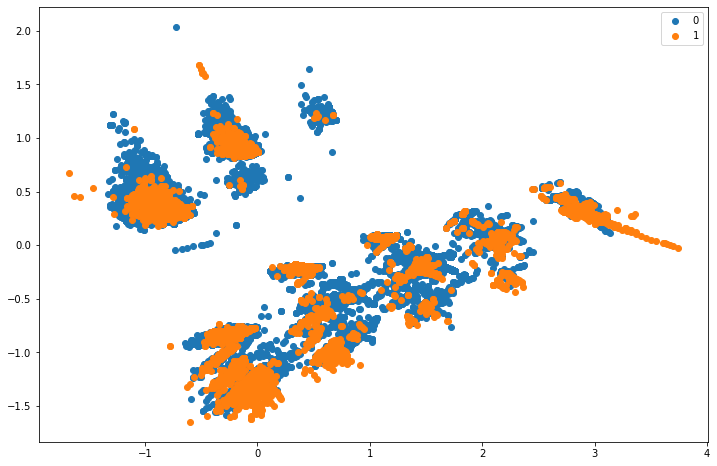

In [ ]:
# Plot first 2 PCA features and colour by target variable
plt.figure(figsize=(12, 8));
groups = df.groupby("isFraud")
for name, group in groups:
    plt.scatter(group["PCA_V_0"], group["PCA_V_1"], label=name)
plt.legend()
plt.show()

## 9. Feature Encoding

- **Frequency Encoding**

Create a list of variables that needs to be encoded using frequency encoding. Let's note down the features which has more than 30 unique values,  We would using frequency encoding for these features only

In [ ]:
cat_columns = df.select_dtypes(include=['object']).columns
len(cat_columns)

30

In [ ]:
binary_columns = [col for col in df.columns if df[col].nunique() == 2]
len(binary_columns)

432

In [ ]:
num_columns = [col for col in df.columns if (col not in cat_columns) & (col not in binary_columns)]
len(num_columns)

92

In [ ]:
cat_columns = cat_columns.to_list() + binary_columns

In [ ]:
# Frequecny encoding variables
frequency_encoded_variables = []
for col in cat_columns:
    if df[col].nunique() > 30:
        print(col, df[col].nunique())
        frequency_encoded_variables.append(col)

id_33 260
DeviceInfo 1786
Date 573349


It's time to encode the variables using frequency encoding

In [ ]:
# Frequecny enocde the variables
for variable in tqdm(frequency_encoded_variables):
    # group by frequency
    fq = df.groupby(variable).size()/len(df)
    # mapping values to dataframe
    df.loc[:, "{}".format(variable)] = df[variable].map(fq)
    cat_columns.remove(variable)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


In [ ]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card2_missing_flag,card3_missing_flag,card4_missing_flag,card5_missing_flag,card6_missing_flag,addr1_missing_flag,addr2_missing_flag,dist1_missing_flag,dist2_missing_flag,P_emaildomain_missing_flag,R_emaildomain_missing_flag,D1_missing_flag,D2_missing_flag,D3_missing_flag,D4_missing_flag,D5_missing_flag,D6_missing_flag,D7_missing_flag,D8_missing_flag,D9_missing_flag,D10_missing_flag,D11_missing_flag,D12_missing_flag,D13_missing_flag,D14_missing_flag,D15_missing_flag,M1_missing_flag,M2_missing_flag,M3_missing_flag,M4_missing_flag,M5_missing_flag,M6_missing_flag,M7_missing_flag,M8_missing_flag,M9_missing_flag,V1_missing_flag,V2_missing_flag,V3_missing_flag,V4_missing_flag,V5_missing_flag,V6_missing_flag,V7_missing_flag,V8_missing_flag,V9_missing_flag,V10_missing_flag,V11_missing_flag,V12_missing_flag,V13_missing_flag,V14_missing_flag,V15_missing_flag,V16_missing_flag,V17_missing_flag,V18_missing_flag,V19_missing_flag,V20_missing_flag,V21_missing_flag,V22_missing_flag,V23_missing_flag,V24_missing_flag,V25_missing_flag,V26_missing_flag,V27_missing_flag,V28_missing_flag,V29_missing_flag,V30_missing_flag,V31_missing_flag,V32_missing_flag,V33_missing_flag,V34_missing_flag,V35_missing_flag,V36_missing_flag,V37_missing_flag,V38_missing_flag,V39_missing_flag,V40_missing_flag,V41_missing_flag,V42_missing_flag,V43_missing_flag,V44_missing_flag,V45_missing_flag,V46_missing_flag,V47_missing_flag,V48_missing_flag,V49_missing_flag,V50_missing_flag,V51_missing_flag,V52_missing_flag,V53_missing_flag,V54_missing_flag,V55_missing_flag,V56_missing_flag,V57_missing_flag,V58_missing_flag,V59_missing_flag,V60_missing_flag,V61_missing_flag,V62_missing_flag,V63_missing_flag,V64_missing_flag,V65_missing_flag,V66_missing_flag,V67_missing_flag,V68_missing_flag,V69_missing_flag,V70_missing_flag,V71_missing_flag,V72_missing_flag,V73_missing_flag,V74_missing_flag,V75_missing_flag,V76_missing_flag,V77_missing_flag,V78_missing_flag,V79_missing_flag,V80_missing_flag,V81_missing_flag,V82_missing_flag,V83_missing_flag,V84_missing_flag,V85_missing_flag,V86_missing_flag,V87_missing_flag,V88_missing_flag,V89_missing_flag,V90_missing_flag,V91_missing_flag,V92_missing_flag,V93_missing_flag,V94_missing_flag,V95_missing_flag,V96_missing_flag,V97_missing_flag,V98_missing_flag,V99_missing_flag,V100_missing_flag,V101_missing_flag,V102_missing_flag,V103_missing_flag,V104_missing_flag,V105_missing_flag,V106_missing_flag,V107_missing_flag,V108_missing_flag,V109_missing_flag,V110_missing_flag,V111_missing_flag,V112_missing_flag,V113_missing_flag,V114_missing_flag,V115_missing_flag,V116_missing_flag,V117_missing_flag,V118_missing_flag,V119_missing_flag,V120_missing_flag,V121_missing_flag,V122_missing_flag,V123_missing_flag,V124_missing_flag,V125_missing_flag,V126_missing_flag,V127_missing_flag,V128_missing_flag,V129_missing_flag,V130_missing_flag,V131_missing_flag,V132_missing_flag,...,V170_missing_flag,V171_missing_flag,V172_missing_flag,V173_missing_flag,V174_missing_flag,V175_missing_flag,V176_missing_flag,V177_missing_flag,V178_missing_flag,V179_missing_flag,V180_missing_flag,V181_missing_flag,V182_missing_flag,V183_missing_flag,V184_missing_flag,V185_missing_flag,V186_missing_flag,V187_missing_flag,V188_missing_flag,V189_missing_flag,V190_missing_flag,V191_missing_flag,V192_missing_flag,V193_missing_flag,V194_missing_flag,V195_missing_flag,V196_missing_flag,V197_missing_flag,V198_missing_flag,V199_missing_flag,V200_missing_flag,V201_missing_flag,V202_missing_flag,V203_missing_flag,V204_missing_flag,V205_missing_flag,V206_miss

- **Label encoding**


In [ ]:
# Label encode the variables
for col in cat_columns:
    lbl        = LabelEncoder()
    lbl.fit(list(df[col].values))
    df[col] = lbl.transform(list(df[col].values))

Let's reduce the memory usage as lot of new columns has been added to the data frame

In [ ]:
# Reduce memory usage
df = reduce_mem_usage(df)

Mem. usage decreased to 361.00 Mb (82.7% reduction)


In [ ]:
# Save train df to csv file
df.to_csv("Intermediate_Datasets/df_intermediate2.csv", index = False)